# 草，预处理出问题了

标准栅格发现有空洞，于是在修补的过程中，一边跑代码，一边在写考虑后面建模的代码

In [12]:
import xarray as xr
import matplotlib.pyplot as plt

# 读取数据
ds = xr.open_dataset(r'D:\xarray\abandon_2\chunk_4_49.nc')
ds_2 = xr.open_dataset(r'D:\xarray\abandonment_chunkall\chunk_4_49.nc')


ds_2



<xarray.Dataset> Size: 35MB
Dimensions:               (lat: 500, lon: 500, time: 31)
Coordinates:
  * lat                   (lat) float64 4kB 73.33 73.32 73.31 ... 69.18 69.17
  * lon                   (lon) float64 4kB 24.17 24.18 24.19 ... 28.32 28.33
  * time                  (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Data variables:
    abandonment_year      (lat, lon) float32 1MB ...
    abandonment_duration  (lat, lon) float32 1MB ...
    recultivation         (lat, lon) float32 1MB ...
    current_abandonment   (lat, lon) float32 1MB ...
    landcover             (time, lat, lon) float32 31MB ...

In [6]:
import os
import gc
import numpy as np
import xarray as xr
import rioxarray

# —— 1. 路径设置 ——
tif_path = r'D:\Photovoltaic_data\Global_rast_gdpTot_1990_2020_30arcsec.tif'
nc_path  = r'D:\xarray\aligned2\firstmask.nc'

os.makedirs(os.path.dirname(nc_path), exist_ok=True)

# —— 2. 读取 GeoTIFF 为 DataArray ——
da = rioxarray.open_rasterio(tif_path, masked=True)
# 取第一个波段而不是squeeze
if 'band' in da.dims:
    da = da.isel(band=0)

# 重命名坐标一致为 lat/lon
if 'x' in da.dims and 'y' in da.dims:
    da = da.rename({'x': 'lon', 'y': 'lat'})


# —— 3. 构建陆域掩膜 ——
land_mask = da.notnull().astype(bool)
land_mask.name = 'land_mask'
land_mask.attrs['description'] = 'True where population density is valid'

# —— 4. 打包为 Dataset ——
ds = xr.Dataset(
    {
        'land_mask':   land_mask
    },
    coords={'lat': da['lat'], 'lon': da['lon']},
    attrs={'title': 'Population Density with simple land mask'}
)

# —— 5. 优化编码并保存 ——
encoding = {
    'land_mask': {
        'dtype': 'bool', 'zlib': True, 'complevel': 5
    }
}
ds.to_netcdf(nc_path, encoding=encoding)

# —— 6. 清理内存 ——
del ds, da, land_mask
gc.collect()

print(f"✅ 已保存简单 NetCDF：{nc_path}")


✅ 已保存简单 NetCDF：D:\xarray\aligned2\firstmask.nc


In [7]:
import xarray as xr
from pathlib import Path
import numpy as np

MASTER = r"D:\xarray\aligned2\firstmask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
OUT    = r"D:\xarray\aligned2\master_final.nc"

# 1) 读取
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask          # (lat, lon 或 y,x)

# 2) 若 final 用 y/x → 改成 lat/lon（不依赖 rioxarray）
if {"x","y"}.issubset(final.dims):
    final = final.rename({"x":"lon", "y":"lat"})

# 3) 对齐：最近邻插值到 final 网格
# 将布尔类型转换为数值类型，因为interp只能处理数值类型数组
master_numeric = master.astype("uint8")  # 将布尔值转换为0和1
aligned = master_numeric.interp(
    lon=final.lon, lat=final.lat, method="nearest"
).astype("uint8")

# 4) 保留 0/1，写 NetCDF
aligned.to_dataset(name="land_mask").to_netcdf(
    OUT, encoding={"land_mask":{"zlib":True,"complevel":4}}
)

print("✓ 新 land_mask 已输出:", OUT)


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


✓ 新 land_mask 已输出: D:\xarray\aligned2\master_final.nc


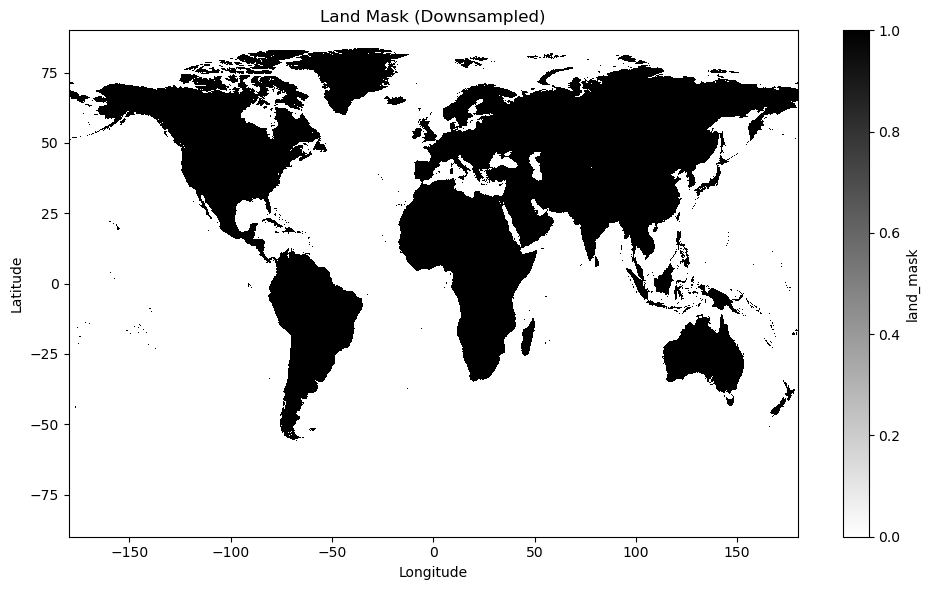

Dataset shape: (21600, 43200)
Data type: uint8


In [8]:
newmaster_path = OUT

newmaster = xr.open_dataset(newmaster_path)

import matplotlib.pyplot as plt

# The dataset is too large to plot directly, so we'll downsample it
# Downsample the data to avoid memory error
n = 10  # Adjust this value based on your memory constraints
downsampled = newmaster.land_mask.isel(lat=slice(None, None, n), lon=slice(None, None, n))

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the downsampled data with simple colors
downsampled.plot(ax=ax, cmap='binary', add_colorbar=True)

# Add basic title and labels
plt.title('Land Mask (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Display basic information about the dataset
print(f"Dataset shape: {newmaster.land_mask.shape}")
print(f"Data type: {newmaster.land_mask.dtype}")


# 气候数据

## RSDS数据

In [15]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_rsds")
    OUT_DIR  = Path(r"D:\xarray\aligned2\rsds")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019|2018)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()

Initial memory usage:
Memory usage: 2049.55 MB


Processing files:   0%|          | 0/36 [00:00<?, ?it/s]

Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_01_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_02_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_03_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_04_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_05_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_06_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_07_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_08_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_09_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_10_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_11_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_12_V.2.1.nc

Processing CHELSA_rsds_2018_01_V.2.1.tif
Memory usage: 2050.13 MB


Memory usage: 2156.51 MB


Memory usage: 2242.86 MB


Memory usage: 2587.31 MB


Memory usage: 3298.07 MB


Processing chunks: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]

Memory usage: 4009.54 MB


Memory usage: 2977.49 MB


Processing files:  36%|███▌      | 13/36 [11:15<19:55, 51.97s/it]

Successfully processed: CHELSA_rsds_2018_01_V.2.1.tif

Processing CHELSA_rsds_2018_02_V.2.1.tif
Memory usage: 2054.95 MB


Memory usage: 2157.77 MB


Memory usage: 2243.60 MB


Memory usage: 2607.09 MB


Memory usage: 3318.12 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.32s/it]

Memory usage: 4028.36 MB


Memory usage: 2956.01 MB


Processing files:  39%|███▉      | 14/36 [22:20<41:18, 112.64s/it]

Successfully processed: CHELSA_rsds_2018_02_V.2.1.tif

Processing CHELSA_rsds_2018_03_V.2.1.tif
Memory usage: 2100.45 MB


Memory usage: 2206.15 MB


Memory usage: 2292.34 MB


Memory usage: 2612.73 MB


Memory usage: 3323.30 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.31s/it]

Memory usage: 4033.34 MB


Memory usage: 2969.14 MB


Processing files:  42%|████▏     | 15/36 [33:30<1:03:36, 181.74s/it]

Successfully processed: CHELSA_rsds_2018_03_V.2.1.tif

Processing CHELSA_rsds_2018_04_V.2.1.tif
Memory usage: 2110.79 MB


Memory usage: 2218.74 MB


Memory usage: 2304.60 MB


Memory usage: 2605.41 MB


Memory usage: 3316.23 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

Memory usage: 4026.57 MB


Memory usage: 2972.14 MB


Processing files:  44%|████▍     | 16/36 [44:45<1:25:19, 255.98s/it]

Successfully processed: CHELSA_rsds_2018_04_V.2.1.tif

Processing CHELSA_rsds_2018_05_V.2.1.tif
Memory usage: 2056.32 MB


Memory usage: 2163.25 MB


Memory usage: 2249.59 MB


Memory usage: 2597.88 MB


Memory usage: 3308.62 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

Memory usage: 4019.81 MB


Memory usage: 2937.19 MB


Processing files:  47%|████▋     | 17/36 [55:46<1:43:43, 327.57s/it]

Successfully processed: CHELSA_rsds_2018_05_V.2.1.tif

Processing CHELSA_rsds_2018_06_V.2.1.tif
Memory usage: 2094.78 MB


Memory usage: 2202.12 MB


Memory usage: 2287.65 MB


Memory usage: 2612.10 MB


Memory usage: 3321.84 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.32s/it]

Memory usage: 4032.52 MB


Memory usage: 2964.41 MB


Processing files:  50%|█████     | 18/36 [1:06:51<1:58:40, 395.56s/it]

Successfully processed: CHELSA_rsds_2018_06_V.2.1.tif

Processing CHELSA_rsds_2018_07_V.2.1.tif
Memory usage: 2092.29 MB


Memory usage: 2198.20 MB


Memory usage: 2284.54 MB


Memory usage: 2606.78 MB


Memory usage: 3318.10 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]

Memory usage: 4029.59 MB


Memory usage: 2979.00 MB


Processing files:  53%|█████▎    | 19/36 [1:18:51<2:12:38, 468.12s/it]

Successfully processed: CHELSA_rsds_2018_07_V.2.1.tif

Processing CHELSA_rsds_2018_08_V.2.1.tif
Memory usage: 2114.22 MB


Memory usage: 2219.95 MB


Memory usage: 2306.40 MB


Memory usage: 2605.59 MB


Memory usage: 3316.80 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]

Memory usage: 4027.73 MB


Memory usage: 2979.48 MB


Processing files:  56%|█████▌    | 20/36 [1:30:32<2:19:54, 524.63s/it]

Successfully processed: CHELSA_rsds_2018_08_V.2.1.tif

Processing CHELSA_rsds_2018_09_V.2.1.tif
Memory usage: 2112.55 MB


Memory usage: 2220.42 MB


Memory usage: 2306.85 MB


Memory usage: 2605.23 MB


Memory usage: 3316.50 MB


Processing chunks: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]

Memory usage: 4027.89 MB


Memory usage: 3018.28 MB


Processing files:  58%|█████▊    | 21/36 [1:41:34<2:19:59, 559.94s/it]

Successfully processed: CHELSA_rsds_2018_09_V.2.1.tif

Processing CHELSA_rsds_2018_10_V.2.1.tif
Memory usage: 2108.06 MB


Memory usage: 2215.61 MB


Memory usage: 2301.95 MB


Memory usage: 2611.62 MB


Memory usage: 3322.11 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.31s/it]

Memory usage: 4031.81 MB


Memory usage: 2971.64 MB


Processing files:  61%|██████    | 22/36 [1:52:38<2:17:10, 587.92s/it]

Successfully processed: CHELSA_rsds_2018_10_V.2.1.tif

Processing CHELSA_rsds_2018_11_V.2.1.tif
Memory usage: 2128.41 MB


Memory usage: 2235.26 MB


Memory usage: 2321.71 MB


Memory usage: 2606.49 MB


Memory usage: 3316.61 MB


Processing chunks: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]

Memory usage: 4026.14 MB


Memory usage: 2987.13 MB


Processing files:  64%|██████▍   | 23/36 [2:03:34<2:11:26, 606.65s/it]

Successfully processed: CHELSA_rsds_2018_11_V.2.1.tif

Processing CHELSA_rsds_2018_12_V.2.1.tif
Memory usage: 2109.16 MB


Memory usage: 2218.98 MB


Memory usage: 2305.40 MB


Memory usage: 2601.70 MB


Memory usage: 3312.51 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.30s/it]

Memory usage: 4024.05 MB


Memory usage: 3019.75 MB


Processing files: 100%|██████████| 36/36 [2:14:37<00:00, 224.37s/it]  

Successfully processed: CHELSA_rsds_2018_12_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_01_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_02_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_03_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_04_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_05_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_06_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_07_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_08_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_09_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_10_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_11_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2019_12_V.2.1.nc

Final memory usage:
M

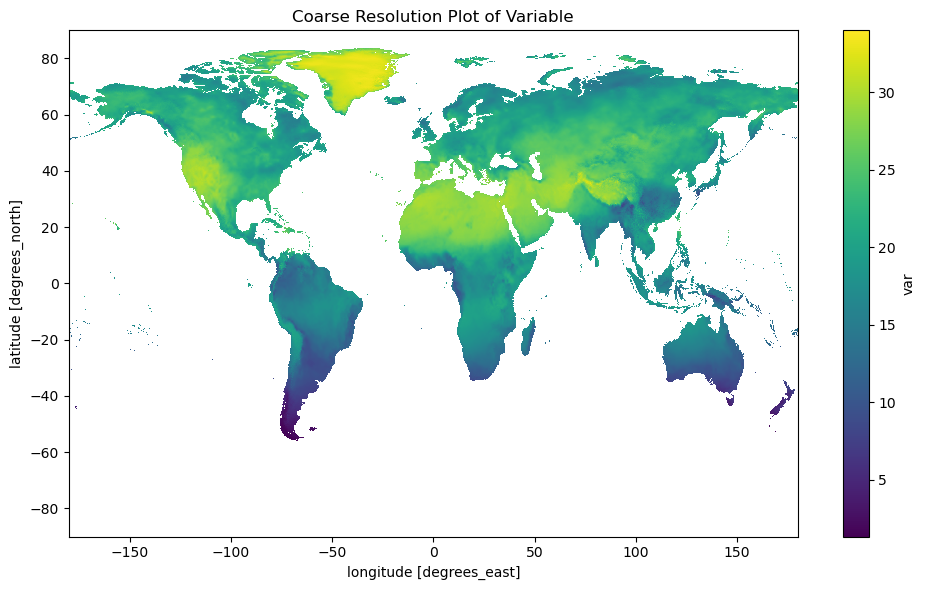

<xarray.Dataset> Size: 4GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band         int32 4B ...
    time         datetime64[ns] 8B ...
Data variables:
    var          (lat, lon) float32 4GB nan nan nan nan nan ... nan nan nan nan

In [2]:
import xarray as xr 

ds_path=r'D:\xarray\aligned2\rsds\CHELSA_rsds_2015_06_V.2.1.nc'
ds=xr.open_dataset(ds_path)
import matplotlib.pyplot as plt

# Plot the variable with coarse resolution for better performance
plt.figure(figsize=(10, 6))
ds['var'].coarsen(lat=20, lon=20).mean().plot()
plt.title('Coarse Resolution Plot of Variable')
plt.tight_layout()
plt.show()





In [6]:
MASTER = r"D:\xarray\aligned2\master_final.nc"
ds = xr.open_dataset(ds_path)
FINAL = r"D:\xarray\final_mask_1km_new.nc"

# 打印三者的经度与纬度分辨率，并观察小数位数后几位
master_ds = xr.open_dataset(MASTER)
final_ds = xr.open_dataset(FINAL)

print("MASTER resolution:")
print(f"Longitude resolution: {master_ds.lon[1] - master_ds.lon[0]:.15f}")
print(f"Latitude resolution: {master_ds.lat[0] - master_ds.lat[1]:.15f}")

print("\nds resolution:")
print(f"Longitude resolution: {ds.lon[1] - ds.lon[0]:.15f}")
print(f"Latitude resolution: {ds.lat[0] - ds.lat[1]:.15f}")

print("\nFINAL resolution:")
print(f"Longitude resolution: {final_ds.lon[1] - final_ds.lon[0]:.15f}")
print(f"Latitude resolution: {final_ds.lat[0] - final_ds.lat[1]:.15f}")

# 关闭数据集以释放内存
master_ds.close()
final_ds.close()


MASTER resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

ds resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

FINAL resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354


## TAS气温并取平均

In [9]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re

# ───────── 配置 ─────────
MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_tas")
OUT_DIR  = Path(r"D:\xarray\aligned2\tas")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
# 筛选出2015年、2018年和2019年的文件
all_files = list(SRC_DIR.glob("*.tif"))
target_files = []
for fp in all_files:
    # 使用正则表达式检查文件名中是否包含2015、2018或2019年
    if re.search(r'(2015|2018|2019)', fp.stem):
        target_files.append(fp)

for fp in tqdm(target_files, desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果文件已存在，则跳过处理
    if out_nc.exists():
        print(f"Skipping existing file: {out_nc}")
        continue

    try:
        # 2.1 读入时就分块
        da = (
            rxr.open_rasterio(fp, masked=True,
                              chunks={"x": chunk_lon, "y": chunk_lat})
              .squeeze("band", drop=True)
              .rio.set_spatial_dims("x", "y", inplace=False)
              .rename({"x": "lon", "y": "lat"})
        )

        # 2.2 按模板经纬度插值对齐（使用线性插值但降低内存使用）
        # 为了避免内存错误，我们将插值操作分成多个小块处理
        lat_chunks = np.array_split(lat.values, 10)  # 将纬度分成10个块
        da_parts = []
        
        for lat_chunk in lat_chunks:
            # 对每个纬度块进行插值
            da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
            # 应用掩膜
            mask_chunk = mask.sel(lat=lat_chunk)
            da_chunk_masked = da_chunk.where(mask_chunk)
            da_parts.append(da_chunk_masked)
            
            # 立即清理内存
            da_chunk = None
            mask_chunk = None
            gc.collect()
        
        # 沿纬度方向合并所有块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 2.4 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds = da_masked.to_dataset(name=var) \
                      .chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        # 使用compute=True确保立即计算并写入文件
        ds.to_netcdf(out_nc, encoding=encoding, compute=True)

    except Exception as e:
        print(f"Error processing {fp}: {str(e)}")
        # 如果处理失败，删除可能部分写入的文件
        if out_nc.exists():
            try:
                os.remove(out_nc)
                print(f"Removed incomplete file: {out_nc}")
            except:
                print(f"Failed to remove incomplete file: {out_nc}")
    finally:
        # 2.6 关闭 & 回收
        try:
            if 'ds' in locals():
                ds.close()
            if 'da' in locals():
                da = None
            if 'da_masked' in locals():
                da_masked = None
            gc.collect()
        except:
            pass

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs: 100%|██████████| 36/36 [1:17:17<00:00, 128.82s/it]

✅ All done! Aligned files are in: D:\xarray\aligned2\tas


## WIND风速

In [14]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_wind")
    OUT_DIR  = Path(r"D:\xarray\aligned2\wind")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019|2018)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()

Initial memory usage:
Memory usage: 258.36 MB


Processing files:   0%|          | 0/28 [00:00<?, ?it/s]

Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_01_2015_V.2.1.nc

Processing CHELSA_sfcWind_01_2018_V.2.1.tif
Memory usage: 259.84 MB


Memory usage: 1061.04 MB


Memory usage: 1774.82 MB


Memory usage: 2489.16 MB


Memory usage: 3203.36 MB


Processing chunks: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]

Memory usage: 3918.49 MB


Memory usage: 2800.42 MB


Processing files:   7%|▋         | 2/28 [12:32<2:43:02, 376.26s/it]

Successfully processed: CHELSA_sfcWind_01_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_01_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_02_2015_V.2.1.nc

Processing CHELSA_sfcWind_02_2018_V.2.1.tif
Memory usage: 1763.73 MB


Memory usage: 1868.58 MB


Memory usage: 1955.04 MB


Memory usage: 2604.87 MB


Memory usage: 3315.36 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]

Memory usage: 4025.77 MB


Memory usage: 2736.60 MB


Processing files:  18%|█▊        | 5/28 [24:27<1:48:11, 282.24s/it]

Successfully processed: CHELSA_sfcWind_02_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_02_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_03_2015_V.2.1.nc

Processing CHELSA_sfcWind_03_2018_V.2.1.tif
Memory usage: 1808.42 MB


Memory usage: 1913.29 MB


Memory usage: 2000.12 MB


Memory usage: 2602.77 MB


Memory usage: 3314.03 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.33s/it]

Memory usage: 4024.75 MB


Memory usage: 2721.99 MB


Processing files:  29%|██▊       | 8/28 [36:21<1:26:47, 260.39s/it]

Successfully processed: CHELSA_sfcWind_03_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_03_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_04_2015_V.2.1.nc

Processing CHELSA_sfcWind_04_2018_V.2.1.tif
Memory usage: 1890.08 MB


Memory usage: 1994.95 MB


Memory usage: 2081.38 MB


Memory usage: 2598.10 MB


Memory usage: 3309.41 MB


Processing chunks: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]

Memory usage: 4020.96 MB


Memory usage: 2802.16 MB


Processing files:  39%|███▉      | 11/28 [48:10<1:10:58, 250.49s/it]

Successfully processed: CHELSA_sfcWind_04_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_04_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_05_2015_V.2.1.nc

Processing CHELSA_sfcWind_05_2018_V.2.1.tif
Memory usage: 1961.80 MB


Memory usage: 2072.39 MB


Memory usage: 2158.75 MB


Memory usage: 2598.59 MB


Memory usage: 3310.02 MB


Processing chunks: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]

Memory usage: 4021.38 MB


Memory usage: 2874.38 MB


Processing files:  50%|█████     | 14/28 [1:00:00<57:14, 245.35s/it]

Successfully processed: CHELSA_sfcWind_05_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_06_2015_V.2.1.nc

Processing CHELSA_sfcWind_06_2018_V.2.1.tif
Memory usage: 2024.46 MB


Memory usage: 2130.72 MB


Memory usage: 2217.24 MB


Memory usage: 2603.72 MB


Memory usage: 3314.43 MB


Processing chunks: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]

Memory usage: 4023.92 MB


Memory usage: 2894.25 MB


Processing files:  57%|█████▋    | 16/28 [1:11:56<54:57, 274.76s/it]

Successfully processed: CHELSA_sfcWind_06_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_07_2015_V.2.1.nc

Processing CHELSA_sfcWind_07_2018_V.2.1.tif
Memory usage: 2017.36 MB


Memory usage: 2124.41 MB


Memory usage: 2209.77 MB


Memory usage: 2595.46 MB


Memory usage: 3306.55 MB


Processing chunks: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]

Memory usage: 4018.28 MB


Memory usage: 2937.77 MB


Processing files:  64%|██████▍   | 18/28 [1:23:46<49:25, 296.59s/it]

Successfully processed: CHELSA_sfcWind_07_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_08_2015_V.2.1.nc

Processing CHELSA_sfcWind_08_2018_V.2.1.tif
Memory usage: 2045.16 MB


Memory usage: 2153.99 MB


Memory usage: 2240.18 MB


Memory usage: 2608.00 MB


Memory usage: 3318.12 MB


Processing chunks: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

Memory usage: 4027.29 MB


Memory usage: 2919.91 MB


Processing files:  71%|███████▏  | 20/28 [1:35:43<41:51, 313.88s/it]

Successfully processed: CHELSA_sfcWind_08_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_09_2015_V.2.1.nc

Processing CHELSA_sfcWind_09_2018_V.2.1.tif
Memory usage: 2036.58 MB


Memory usage: 2142.87 MB


Memory usage: 2229.30 MB


Memory usage: 2599.67 MB


Memory usage: 3309.96 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.35s/it]

Memory usage: 4020.98 MB


Memory usage: 2927.62 MB


Processing files:  79%|███████▊  | 22/28 [1:47:19<32:21, 323.62s/it]

Successfully processed: CHELSA_sfcWind_09_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_10_2015_V.2.1.nc

Processing CHELSA_sfcWind_10_2018_V.2.1.tif
Memory usage: 2041.74 MB


Memory usage: 2147.35 MB


Memory usage: 2233.80 MB


Memory usage: 2605.89 MB


Memory usage: 3316.37 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]

Memory usage: 4026.83 MB


Memory usage: 2911.77 MB


Processing files:  86%|████████▌ | 24/28 [1:59:24<22:19, 334.94s/it]

Successfully processed: CHELSA_sfcWind_10_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_11_2015_V.2.1.nc

Processing CHELSA_sfcWind_11_2018_V.2.1.tif
Memory usage: 2064.67 MB


Memory usage: 2170.64 MB


Memory usage: 2256.73 MB


Memory usage: 2604.45 MB


Memory usage: 3315.82 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.45s/it]

Memory usage: 4027.44 MB


Memory usage: 2942.92 MB


Processing files:  93%|█████████▎| 26/28 [2:11:25<11:24, 342.36s/it]

Successfully processed: CHELSA_sfcWind_11_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_12_2015_V.2.1.nc

Processing CHELSA_sfcWind_12_2018_V.2.1.tif
Memory usage: 2097.29 MB


Memory usage: 2206.29 MB


Memory usage: 2292.74 MB


Memory usage: 2604.09 MB


Memory usage: 3315.16 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]

Memory usage: 4026.83 MB


Memory usage: 2966.59 MB


Processing files: 100%|██████████| 28/28 [2:23:28<00:00, 307.44s/it]

Successfully processed: CHELSA_sfcWind_12_2018_V.2.1.tif

Final memory usage:
Memory usage: 2067.16 MB
✅ All done! Aligned files are in: D:\xarray\aligned2\wind


## GDMP

In [24]:
from pathlib import Path
import xarray as xr
def collect_gdmp_files(base_dir):
    """
    收集所有GDMP文件夹中的NC文件路径
    
    Parameters:
    -----------
    base_dir : str
        基础目录路径
    
    Returns:
    --------
    list
        包含所有NC文件绝对路径的列表
    """
    base_path = Path(base_dir)
    
    # 获取所有以c_gls_GDMP开头的文件夹
    gdmp_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('c_gls_GDMP')]
    
    # 收集所有NC文件路径
    nc_files = []
    for folder in gdmp_folders:
        nc_files.extend(folder.glob('*.nc'))
    
    # 转换为绝对路径
    nc_files = [str(f.absolute()) for f in nc_files]
    
    return nc_files


base_dir = r"D:\xarray\pre-process\Gross_productivity"

nc_files = collect_gdmp_files(base_dir)
    
print(nc_files)


['D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201506300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_2

In [26]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import re
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
OUT_DIR  = Path(r"D:\xarray\aligned2\gdmp")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# 使用正则表达式筛选2018年的文件
filtered_files = []
for fp in nc_files:
    if re.search(r'2018', fp):
        filtered_files.append(fp)

print(f"找到 {len(filtered_files)} 个2018年，共 {len(nc_files)} 个文件")

# 创建一个已处理文件列表
processed_files = 0
skipped_files = 0

for fp in tqdm(filtered_files, desc="Aligning TIFs"):
    file_path = Path(fp)
    out_nc = OUT_DIR / f"{file_path.stem}.nc"
    
    # 检查输出文件是否已存在，如果存在则跳过
    if out_nc.exists():
        skipped_files += 1
        continue
    
    try:
        # 对于NetCDF文件的特殊处理
        # 使用更小的块大小来减少内存使用
        ds = xr.open_dataset(str(file_path), chunks={'lat': chunk_lat, 'lon': chunk_lon})
        
        # 获取主要变量名（通常是第二个数据变量，第一个可能是坐标或辅助变量）
        var_names = list(ds.data_vars)
        var_name = var_names[0] if len(var_names) == 1 else var_names[1]
        
        # 获取数据数组
        da = ds[var_name]
        
        # 处理可能存在的时间维度
        if 'time' in da.dims:
            da = da.isel(time=0)
        
        # 确保坐标系统正确
        if 'lon' in da.dims and 'lat' in da.dims:
            # 使用float32而不是float64来减少内存使用
            da = da.astype('float64')
            
            # 使用双线性插值进行重采样（对于连续数据如GDMP更合适）
            da_al = da.interp(lon=lon, lat=lat, method="linear")
            
            # 应用陆地掩膜
            da_masked = da_al.where(mask)
            
            # 构造输出数据集
            out_ds = da_masked.to_dataset(name=var_name)
            
            # 设置压缩和分块参数
            encoding = {
                var_name: {
                    "zlib": True,
                    "complevel": 5,
                    "chunksizes": (chunk_lat, chunk_lon),
                    "_FillValue": np.nan,  # 使用NaN作为填充值
                    "dtype": "float64"     # 强制使用float32
                }
            }
            
            # 保存为NetCDF文件
            out_ds.to_netcdf(out_nc, encoding=encoding)
            processed_files += 1
            
            # 立即关闭和清理资源
            out_ds.close()
            del out_ds
            del da_masked
            del da_al
        else:
            print(f"警告: {file_path.name} 缺少经纬度坐标，跳过处理")
            
    except Exception as e:
        print(f"处理 {file_path.name} 时出错: {str(e)}")
    finally:
        # 清理内存
        if 'ds' in locals():
            ds.close()
            del ds
        if 'da' in locals():
            del da
        gc.collect()

print(f"✅ 处理完成! 新处理: {processed_files} 个文件, 跳过: {skipped_files} 个已存在文件")
print(f"对齐后的文件保存在: {OUT_DIR}")


找到 4 个2018年，共 82 个文件


Aligning TIFs:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Aligning TIFs: 100%|██████████| 4/4 [04:08<00:00, 62.15s/it]

✅ 处理完成! 新处理: 1 个文件, 跳过: 3 个已存在文件
对齐后的文件保存在: D:\xarray\aligned2\gdmp


## GDP\人均GDP（已执行）
## 人口、坡度(已经执行)

In [16]:
from pathlib import Path
import xarray as xr
import numpy as np
import logging
from tqdm import tqdm

def check_nc_alignment(directory_path):
    """
    检查指定目录下所有NetCDF文件的对齐情况
    
    Parameters:
    -----------
    directory_path : str or Path
        要检查的目录路径
    
    Returns:
    --------
    dict
        包含检查结果的字典
    """
    # 配置日志
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('nc_alignment_check.log'),
            logging.StreamHandler()
        ]
    )
    
    # 转换为Path对象
    dir_path = Path(directory_path)
    
    # 获取所有.nc文件
    nc_files = list(dir_path.glob("*.nc"))
    if not nc_files:
        logging.error(f"No .nc files found in {directory_path}")
        return None
    
    # 存储检查结果
    results = {
        "total_files": len(nc_files),
        "aligned_files": [],
        "misaligned_files": [],
        "errors": []
    }
    
    # 读取第一个文件作为参考
    try:
        ref_ds = xr.open_dataset(nc_files[0])
        ref_lat = ref_ds.lat.values
        ref_lon = ref_ds.lon.values
        ref_lat_size = len(ref_lat)
        ref_lon_size = len(ref_lon)
        ref_lat_min, ref_lat_max = ref_lat.min(), ref_lat.max()
        ref_lon_min, ref_lon_max = ref_lon.min(), ref_lon.max()
        
        logging.info(f"Reference file: {nc_files[0].name}")
        logging.info(f"Reference grid size: {ref_lat_size}x{ref_lon_size}")
        logging.info(f"Reference lat range: [{ref_lat_min}, {ref_lat_max}]")
        logging.info(f"Reference lon range: [{ref_lon_min}, {ref_lon_max}]")
        
        # 检查其他文件
        for nc_file in tqdm(nc_files[1:], desc="Checking files"):
            try:
                ds = xr.open_dataset(nc_file)
                
                # 检查坐标是否存在
                if 'lat' not in ds.coords or 'lon' not in ds.coords:
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": "Missing lat/lon coordinates"
                    })
                    continue
                
                # 检查网格大小
                lat_size = len(ds.lat)
                lon_size = len(ds.lon)
                if lat_size != ref_lat_size or lon_size != ref_lon_size:
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": f"Grid size mismatch: {lat_size}x{lon_size} vs {ref_lat_size}x{ref_lon_size}"
                    })
                    continue
                
                # 检查坐标范围
                lat_min, lat_max = ds.lat.min().values, ds.lat.max().values
                lon_min, lon_max = ds.lon.min().values, ds.lon.max().values
                
                if not (np.allclose(lat_min, ref_lat_min) and 
                       np.allclose(lat_max, ref_lat_max) and
                       np.allclose(lon_min, ref_lon_min) and
                       np.allclose(lon_max, ref_lon_max)):
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": f"Coordinate range mismatch"
                    })
                    continue
                
                # 检查坐标值
                if not (np.allclose(ds.lat.values, ref_lat) and 
                       np.allclose(ds.lon.values, ref_lon)):
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": "Coordinate values mismatch"
                    })
                    continue
                
                # 如果通过所有检查，则添加到对齐文件列表
                results["aligned_files"].append(nc_file.name)
                
            except Exception as e:
                results["errors"].append({
                    "file": nc_file.name,
                    "error": str(e)
                })
            finally:
                if 'ds' in locals():
                    ds.close()
        
        # 关闭参考数据集
        ref_ds.close()
        
        # 打印总结
        logging.info("\n=== Alignment Check Summary ===")
        logging.info(f"Total files checked: {results['total_files']}")
        logging.info(f"Aligned files: {len(results['aligned_files'])}")
        logging.info(f"Misaligned files: {len(results['misaligned_files'])}")
        logging.info(f"Files with errors: {len(results['errors'])}")
        
        if results["misaligned_files"]:
            logging.info("\nMisaligned files:")
            for file_info in results["misaligned_files"]:
                logging.info(f"- {file_info['file']}: {file_info['reason']}")
        
        if results["errors"]:
            logging.info("\nFiles with errors:")
            for error_info in results["errors"]:
                logging.info(f"- {error_info['file']}: {error_info['error']}")
        
        return results
        
    except Exception as e:
        logging.error(f"Error processing reference file: {str(e)}")
        return None

# 使用示例
if __name__ == "__main__":
    directory = r"D:\xarray\aligned2\social"
    results = check_nc_alignment(directory)

2025-05-12 16:39:10,510 - INFO - Reference file: Dist_GUR_masked_2015.nc
2025-05-12 16:39:10,522 - INFO - Reference grid size: 21600x43200
2025-05-12 16:39:10,524 - INFO - Reference lat range: [-89.99583333333334, 89.99583333333335]
2025-05-12 16:39:10,527 - INFO - Reference lon range: [-179.9958333333333, 179.9958333333333]
Checking files: 100%|██████████| 14/14 [00:00<00:00, 15.74it/s]
2025-05-12 16:39:11,430 - INFO - 
=== Alignment Check Summary ===
2025-05-12 16:39:11,432 - INFO - Total files checked: 15
2025-05-12 16:39:11,434 - INFO - Aligned files: 14
2025-05-12 16:39:11,434 - INFO - Misaligned files: 0
2025-05-12 16:39:11,437 - INFO - Files with errors: 0


# 特征集构建

逻辑：特征集尽量保保持数据的一致性

情况说明：
    气候数据集基本上都有三个年份的数据，但仅更新到2019年，因此直接用2019年替代2020年数据。
    
    其中，风速仅更新到2018年，因此用1/3的变化量+2018来进行估计。

    对于仅有2015与2020年的数据（GUR距离），采用3/5的变化量+2015=2018来对2018年进行估计。

    对于仅有1年的数据
    

In [1]:
# 列出 D:\xarray\aligned2 下的所有文件夹

import os

# 确保没有名为print的变量覆盖了内置print函数
if 'print' in locals() or 'print' in globals():
    del print

aligned_dir = r"D:\xarray\aligned2"
folders = [f for f in os.listdir(aligned_dir) if os.path.isdir(os.path.join(aligned_dir, f))]

# 检查每个文件夹下是否存在 'mean' 子目录
for folder in folders:
    folder_path = os.path.join(aligned_dir, folder)
    mean_path = os.path.join(folder_path, 'mean')
    if os.path.isdir(mean_path):
        # 将当前元素名称加上 '\mean'
        folders[folders.index(folder)] = folder + '\\mean'

# 创建一个新的dir_list，包含特定的文件夹，使用绝对路径
dir_list = [
            os.path.join(aligned_dir, folders[1]),
            os.path.join(aligned_dir, folders[5]),
            os.path.join(aligned_dir, folders[6]),
            os.path.join(aligned_dir, folders[7]),
            os.path.join(aligned_dir, folders[8])]

for i in dir_list:
    print(i)


D:\xarray\aligned2\gdmp\mean
D:\xarray\aligned2\rsds\mean
D:\xarray\aligned2\social
D:\xarray\aligned2\tas\mean
D:\xarray\aligned2\wind\mean


In [4]:
def time_and_name(path_in, feature, year=None):
    """
    处理NetCDF文件：打开文件，重命名变量，对于动态变量添加时间维度
    
    Args:
        path_in: 输入文件路径
        feature: 特征名称
        year: 年份（对于静态变量可以为None）
        
    Returns:
        处理后的xarray数据集
    """
    # 使用chunks='auto'以启用延迟计算和减少内存使用
    ds = xr.open_dataset(path_in, chunks='auto')

    # 取出原始唯一变量名，重命名为 feature
    orig_var = list(ds.data_vars)[0]
    ds = ds.rename({orig_var: feature})

    # 如果是动态变量（有年份），则扩展出 time 维度
    if year is not None:
        ds = ds.expand_dims({
            "time": [np.datetime64(f"{year}-01-01", 'ns')]
        })

        # 设置 CF-标准的 time 属性
        ds["time"].attrs.update({
            "long_name": "time",
            "standard_name": "time",
            "axis": "T"
        })
    
    return ds

def save_nc_file(ds, path_out):
    """
    保存处理后的NetCDF文件，使用分块计算减少内存消耗
    
    Args:
        ds: 要保存的xarray数据集
        path_out: 输出文件路径
    """
    # 使用计算模式和分块写入来减少内存消耗
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars}
    
    # 使用dask进行并行计算并写入文件
    ds.to_netcdf(path_out, encoding=encoding)
    print(f"已写入：{path_out}")

# 源目录和目标目录
src_dir = dir_list
dst_dir = r"D:\xarray\aligned2\Feature_all"
os.makedirs(dst_dir, exist_ok=True)

import re
import numpy as np
import xarray as xr
import gc
from tqdm.notebook import tqdm

# 计算总文件数量
total_files = 0
for src_folder in src_dir:
    nc_files = [f for f in os.listdir(src_folder) if f.endswith('.nc')]
    total_files += len(nc_files)

# 创建总进度条
with tqdm(total=total_files, desc="处理文件") as pbar:
    # 逐个处理文件以减少内存占用
    for src_folder in src_dir:
        # 获取文件夹中的所有nc文件
        nc_files = [f for f in os.listdir(src_folder) if f.endswith('.nc')]
        
        for fn in nc_files:
            # 尝试匹配动态变量格式 (feature_YYYY.nc)
            m = re.match(r"([^_]+)_(\d{4})\.nc", fn)
            
            path_in = os.path.join(src_folder, fn)
            path_out = os.path.join(dst_dir, fn)
            
            if m:
                # 动态变量处理
                feature, year = m.group(1), int(m.group(2))
                processed_ds = time_and_name(path_in, feature, year)
            else:
                # 静态变量处理（如 DEM.nc）
                feature = os.path.splitext(fn)[0]  # 获取文件名（不含扩展名）
                processed_ds = time_and_name(path_in, feature)  # 不传入year参数
            
            # 保存文件
            save_nc_file(processed_ds, path_out)
            
            # 显式关闭数据集并清理内存
            processed_ds.close()
            del processed_ds
            gc.collect()
            
            # 更新总进度条
            pbar.update(1)

处理文件:   0%|          | 0/26 [00:00<?, ?it/s]

已写入：D:\xarray\aligned2\Feature_all\gdmp_2015.nc
已写入：D:\xarray\aligned2\Feature_all\gdmp_2018.nc
已写入：D:\xarray\aligned2\Feature_all\gdmp_2020.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2015.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2018.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2020.nc
已写入：D:\xarray\aligned2\Feature_all\DEM.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2018.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2020.nc
已写入：D:\xarray\aligned2\Feature_all\GDPtot_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GDPtot_2020.nc
已写入：D:\xarray\aligned2\Feature_all\GURdist_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GURdist_2020.nc
已写入：D:\xarray\aligned2\Feature_all\Population_2015.nc
已写入：D:\xarray\aligned2\Feature_all\Population_2020.nc
已写入：D:\xarray\aligned2\Feature_all\Powerdist.nc
已写入：D:\xarray\aligned2\Feature_all\PrimaryRoad.nc
已写入：D:\xarray\aligned2\Feature_all\SecondaryRoad.nc
已写入：D:\xarray\aligned2\Feature_all\Slope.nc
已写入：D:\xarray\align

In [6]:
plot_dir = r'D:\xarray\aligned2\Feature_all'

# Print information about files in the directory
print("Files in directory:", plot_dir)
print("\nDetailed information about each file:")
print("-" * 80)
print(f"{'Filename':<25} {'Variable':<15} {'Year':<10} {'Resolution':<20} {'Dimensions (rows x cols)':<20}")
print("-" * 80)

for filename in os.listdir(plot_dir):
    if filename.endswith('.nc'):
        try:
            # Extract variable name and year from filename
            parts = filename.split('_')
            if len(parts) >= 2 and parts[1].replace('.nc', '').isdigit():
                variable = parts[0]
                year = parts[1].replace('.nc', '')
            else:
                variable = filename
                year = "N/A"
                
            # Open dataset to get resolution and dimensions
            filepath = os.path.join(plot_dir, filename)
            ds = xr.open_dataset(filepath)
            
            # Calculate resolution
            if 'lat' in ds.dims and 'lon' in ds.dims:
                lat_res = abs(float(ds.lat[1] - ds.lat[0]))
                lon_res = abs(float(ds.lon[1] - ds.lon[0]))
                resolution = f"{lat_res:.6f}° x {lon_res:.6f}°"
                # Use ds.sizes instead of ds.dims to avoid FutureWarning
                rows = ds.sizes['lat']
                cols = ds.sizes['lon']
                dimensions = f"{rows} x {cols}"
            else:
                resolution = "Unknown"
                dimensions = "Unknown"
                
            print(f"{filename:<25} {variable:<15} {year:<10} {resolution:<20} {dimensions:<20}")
            ds.close()
        except Exception as e:
            print(f"{filename:<25} Error: {str(e)}")
            
print("-" * 80)


Files in directory: D:\xarray\aligned2\Feature_all

Detailed information about each file:
--------------------------------------------------------------------------------
Filename                  Variable        Year       Resolution           Dimensions (rows x cols)
--------------------------------------------------------------------------------
DEM.nc                    DEM.nc          N/A        0.008333° x 0.008333° 21600 x 43200       
gdmp_2015.nc              gdmp            2015       0.008333° x 0.008333° 21600 x 43200       
gdmp_2018.nc              gdmp            2018       0.008333° x 0.008333° 21600 x 43200       
gdmp_2020.nc              gdmp            2020       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2015.nc             GDPpc           2015       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2018.nc             GDPpc           2018       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2020.nc             GDPpc           2020       0.008333° x 0.008333

In [2]:
# Open all files in Feature_all directory
ds_all = xr.open_mfdataset(
    "D:/xarray/aligned2/Feature_all/*.nc",
    combine    = "by_coords",       # 用坐标自动对齐／拼接
    chunks     = {"time":1, "lat":500, "lon":500},
    parallel   = True
)

# Print all variables in the dataset
print("\nVariables in Feature_all:")
print("-" * 40)
for var_name, var in ds_all.data_vars.items():
    print(f"Variable: {var_name}")
    print(f"Dimensions: {var.dims}")
    print(f"Shape: {var.shape}")
    print("-" * 40)

ds_all

c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The spec


Variables in Feature_all:
----------------------------------------
Variable: DEM
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: GDPpc
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: GDPtot
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: GURdist
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: Population
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: Powerdist
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: PrimaryRoad
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: SecondaryRoad
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: Slope


<xarray.Dataset> Size: 146GB
Dimensions:        (lon: 43200, lat: 21600, time: 3)
Coordinates:
    spatial_ref    int32 4B 0
  * lon            (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * lat            (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band           int32 4B 1
  * time           (time) datetime64[ns] 24B 2015-01-01 2018-01-01 2020-01-01
Data variables: (12/14)
    DEM            (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    GDPpc          (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    GDPtot         (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    GURdist        (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    Population     (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    Powerdist      (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    ...             ...
    Slope          (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    TertiaryRoad   (lat, lon) float64 7GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    gdmp           (time, lat, lon) float64 22GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    rsds           (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    tas            (time, lat, lon) float64 22GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    wind           (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>

### 线性差值
1.针对只有2020和2015的，差值生成2018；
2.针对缺少2020的，用2019替代（减少误差传播）；
3.针对风速，差值生成2020；

In [1]:
import xarray as xr
import numpy as np
import os
from tqdm import tqdm

# 配置
features = ["GURdist"]
y0, y1, yt = 2015, 2018 , 2020
weight = (yt - y1) / (y1 - y0)  # =3/5
src_dir = r"D:\xarray\aligned2\GURdist"  # 修改：src_dir = r"D:/xarray/aligned2/Feature_all"
out_dir = src_dir
os.makedirs(out_dir, exist_ok=True)

for feat in tqdm(features, desc="处理特征"):
    # 按需打开 2015 和 2020 两个文件
    f0 = os.path.join(src_dir, f"{feat}_{y0}.nc")
    f1 = os.path.join(src_dir, f"{feat}_{y1}.nc")
    
    # 先打开数据集查看原始分块
    with xr.open_dataset(f1) as temp_ds:
        # Check if spatial_ref exists and drop it
        if 'spatial_ref' in temp_ds:
            temp_ds = temp_ds.drop_vars('spatial_ref')
            # Save the modified dataset
            temp_ds.to_netcdf(os.path.join('D:/xarray/aligned2/Feature_all', os.path.basename(f1)))
            
        print("\nDataset Info:")
        print("-" * 40)
        print(f"Dimensions: {temp_ds.dims}")
        print("\nCoordinates:")
        for coord_name, coord in temp_ds.coords.items():
            print(f"{coord_name}: {coord.dims} {coord.shape}")
        print("\nData Variables:") 
        for var_name, var in temp_ds.data_vars.items():
            print(f"{var_name}:")
            print(f"  Dimensions: {var.dims}")
            print(f"  Shape: {var.shape}")
            print(f"  Dtype: {var.dtype}")
            print(f"  Attributes: {var.attrs}")


处理特征: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Dataset Info:
----------------------------------------
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1, 'lon': 43200, 'lat': 21600})

Coordinates:
time: ('time',) (1,)
lon: ('lon',) (43200,)
lat: ('lat',) (21600,)

Data Variables:
GURdist:
  Dimensions: ('time', 'lat', 'lon')
  Shape: (1, 21600, 43200)
  Dtype: float32
  Attributes: {}


In [5]:
import xarray as xr
import numpy as np
import os
from tqdm import tqdm
from dask.diagnostics import ProgressBar

# 配置
features = ["GURdist"]
y0, y1, yt = 2015, 2020, 2018  # 修改：y0=2015, y1=2020, yt=2018 
weight = (yt - y0) / (y1 - y0)  # 修改：(2018-2015)/(2020-2015) = 3/5
src_dir = r"D:/xarray/aligned2/Feature_all"
out_dir = src_dir
os.makedirs(out_dir, exist_ok=True)

for feat in tqdm(features, desc="处理特征"):
    # 1) 打开 2015 和 2020 两个文件，只读这一变量，并保留分块
    ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
    ds1 = xr.open_dataset(f"{src_dir}/{feat}_{y1}.nc", chunks={"lat":500,"lon":500})
    v0 = ds0[feat].sel(time=f"{y0}-01-01")  # dims: (lat, lon)
    v1 = ds1[feat].sel(time=f"{y1}-01-01")  # dims: (lat, lon)

    # 2) 懒算线性插值到2018年，结果维度 (lat, lon)
    vi = v0 + (v1 - v0) * weight  # 插值公式：v0 + (v1-v0)*(2018-2015)/(2020-2015)

    # 3) 扩展 time 维度到 2018-01-01
    vi = vi.expand_dims(time=[np.datetime64(f"{yt}-01-01", "ns")])
    vi["time"].attrs.update({
        "long_name":     "time",
        "standard_name": "time", 
        "axis":          "T"
    })
    vi.name = feat

    # 4) 直接转 Dataset，保留 lat/lon 坐标和属性
    ds_out = vi.to_dataset()

    # 5) 写盘编码：分块 + 压缩
    encoding = {
        feat: {
            "chunksizes": (1, 500, 500),
            "zlib": True,
            "complevel": 4
        }
    }
    out_fn = os.path.join(out_dir, f"{feat}_{yt}.nc")

    # 6) 用 Dask ProgressBar 显示写盘进度
    with ProgressBar():
        ds_out.to_netcdf(
            out_fn,
            mode="w",
            format="NETCDF4",
            encoding=encoding
        )
    print(f"已保存：{out_fn}")


处理特征:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:17: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:17: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:18: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds1 = xr.open_dataset(f"{src_dir}/{feat

[########################################] | 100% Completed | 126.25 s


处理特征: 100%|██████████| 1/1 [02:09<00:00, 129.03s/it]

已保存：D:/xarray/aligned2/Feature_all\GURdist_2018.nc


In [13]:
import os
import glob
import xarray as xr
from tqdm import tqdm

# ─── 1. 路径设置 ────────────────────────────────────────────────
# ESA CCI 土地覆盖原始文件（一次完整打开，分块加载）
DS_LAND_PATH = r"D:/xarray/reclass_lccs_1km.nc"

# 撂荒结果分块目录（输入）
ABANDON_CHUNK_DIR = r"D:/xarray/abandon_2"

# 合并后分块目录（输出）
MERGED_CHUNK_DIR = r"D:/xarray/merged_chunk_2"
os.makedirs(MERGED_CHUNK_DIR, exist_ok=True)

# ─── 2. 预打开 ds_land 并设置 Dask chunk ─────────────────────────
ds_land = xr.open_dataset(
    DS_LAND_PATH,
    chunks={"time": 1, "lat": 500, "lon": 500}
)
# 重命名，避免 merge 时冲突
ds_land = ds_land.rename({"lccs_class": "landcover"})

# ─── 3. 列出所有撂荒块文件 ───────────────────────────────────────
chunk_files = sorted(glob.glob(os.path.join(ABANDON_CHUNK_DIR, "*.nc")))

# ─── 4. 逐块处理 ───────────────────────────────────────────────
for infile in tqdm(chunk_files, desc="Merging chunks"):
    # 4.1 打开单个撂荒块
    ds_chunk = xr.open_dataset(infile, chunks={"lat": 500, "lon": 500})

    # 4.2 提取该块的经纬度范围，以便只对这一小范围做下采样
    lat0, lat1 = float(ds_chunk.lat.min()), float(ds_chunk.lat.max())
    lon0, lon1 = float(ds_chunk.lon.min()), float(ds_chunk.lon.max())

    # 4.3 在 ds_land 上先切片再最近邻插值
    ds_land_sub = (
        ds_land
        .sel(lat=slice(lat1, lat0), lon=slice(lon0, lon1))  # 注意：lat slice 从大到小
        .interp(lat=ds_chunk.lat, lon=ds_chunk.lon, method="nearest")
    )

    # 4.4 合并变量
    ds_merged = xr.merge([ds_chunk, ds_land_sub])

    # 4.5 写出到新的 NetCDF
    fname = os.path.basename(infile)
    outfile = os.path.join(MERGED_CHUNK_DIR, fname)
    encoding = {
        var: {"zlib": True, "complevel": 4}
        for var in ds_merged.data_vars
    }
    ds_merged.to_netcdf(outfile, mode="w", encoding=encoding)

    # 4.6 关闭 dataset 释放资源
    ds_chunk.close()
    ds_land_sub.close()
    ds_merged.close()

# ─── 5. 完成 ────────────────────────────────────────────────────
print("All chunks merged and saved to:", MERGED_CHUNK_DIR)


Merging chunks: 100%|██████████| 974/974 [10:55<00:00,  1.49it/s]

All chunks merged and saved to: D:/xarray/merged_chunk_2


In [3]:
import pandas as pd
import geopandas as gpd

# 1. 读入 PV 点 CSV
csv_path = r"D:\xarray\aligned2\pv\PV_2018.csv"
df = pd.read_csv(csv_path)

# 2. 转为 GeoDataFrame，注意字段名是 'lon','lat'
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

# 3. 读入 GADM 边界 GeoPackage（国家一级）
gadm_path = r"D:\xarray\aligned2\process_OSMdata\data\gadm.gpkg"
# 如果文件中有多个图层，替换 layer="level0" 为你的国家图层名
gadm = gpd.read_file(gadm_path, layer="level0")[["GID_0", "geometry"]]

# 4. 空间连接：把每个点落在哪个国家多边形里
gdf2 = gpd.sjoin(
    gdf, gadm,
    how="left",
    predicate="within"
)

# 5. 用 GID_0 填充原来缺失的 country 列
if 'country' in gdf2.columns:
    gdf2['country'] = gdf2['country'].fillna(gdf2['GID_0'])
else:
    # 如果原始没有 country 列，也可以直接新建
    gdf2['country'] = gdf2['GID_0']

# 6. 丢掉中间列并保存
out = gdf2.drop(columns=['geometry', 'index_right', 'GID_0'])
out.to_csv(r"D:\xarray\aligned2\pv\PV_2018_filled.csv", index=False)

print("已生成带国家信息的 CSV：", r"D:\xarray\aligned2\pv\PV_2018_filled.csv")


C:\Users\zpy10\AppData\Local\Temp\ipykernel_36088\1337028303.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  gdf2 = gpd.sjoin(


已生成带国家信息的 CSV： D:\xarray\aligned2\pv\PV_2018_filled.csv


# GUR与电网可达性修正

## 电网距离修正

In [2]:
import os
import tempfile
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray  # noqa: F401
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
from osgeo import gdal
from shapely.geometry import box
from tqdm.auto import tqdm
import dask.array as da
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='CRS mismatch')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')


def compute_powerline_distance(
    template_path: str,
    lines_path: str,
    out_path: str,
    *,
    test: bool = False,
    test_bounds: dict[str, float] | None = None,
    land_mask_var: str = "land_mask",
    land_value: int = 1,
    proj_crs: str = "EPSG:6933",   # 投影用的 CRS（米）
    dtype: str = "float32",
    compress: bool = True,
    window_size: int = 512,
):
    """
    ---------------
    功能：
    ---------------
    1. 先读取原始模板（经纬度 CRS，比如 EPSG:4326），保留它的分辨率、范围、坐标等信息。
    2. 将矢量电力线和模板都重投影到投影 CRS（EPSG:6933）下，在投影空间中做 rasterize + GDAL ComputeProximity，
       得到"米"为单位的距离栅格（dist_m）。
    3. 把投影空间下的距离栅格（带 EPSG:6933 信息）重投影回原始模板的 CRS 和网格，保持原始分辨率。
    4. 用原始模板的 land_mask 打掩膜，然后按块写入 NetCDF，输出即与原始模板在 CRS+分辨率+范围上一致。

    参数：
    ----------
    template_path : str
        原始 template NetCDF 文件路径（比如 master_final.nc），其 CRS 应该是 EPSG:4326。
    lines_path : str
        矢量电力线文件路径（GeoPackage、Shapefile 等），最好在 EPSG:4326 下；如果不是，代码会先转为 EPSG:4326。
    out_path : str
        计算完毕后要输出的 NetCDF 文件路径。
    test : bool
        是否启用"测试模式"——先在经纬度下切块再投影。默认为 False。
    test_bounds : dict 或 None
        测试模式下，传入的经纬度边界：{"minx":..., "miny":..., "maxx":..., "maxy":...}。
    land_mask_var : str
        模板里用于表示"土地掩膜"的变量名，默认为 "land_mask"。
    land_value : int
        在 land_mask_var 里表示"农田/目标区域"的值。非该值区域会被设为 NaN。
    proj_crs : str
        投影 CRS，用来做距离计算（米）。默认为 "EPSG:6933"。
    dtype : str
        输出 NetCDF 里数据类型，默认为 "float32"。
    compress : bool
        是否对输出 NetCDF 做 zlib 压缩，默认为 True。
    window_size : int
        做 rasterize 和写 NetCDF 时的块大小（像元数），默认为 512。

    ---------------
    返回值：
    ---------------
    无，直接把结果写到 out_path。
    """

    # ─────────────
    # 步骤 1：读取 原始模板（经纬度 CRS） 和 矢量
    # ─────────────
    print("🔄 读取原始模板（template）和矢量…")
    # 1.1 读矢量
    lines = gpd.read_file(lines_path, engine="pyogrio")
    # 如果矢量没有 CRS 或不是 EPSG:4326，就先转为 EPSG:4326
    if lines.crs is None or lines.crs.to_string() != "EPSG:4326":
        lines = lines.to_crs("EPSG:4326")

    # 1.2 读 NetCDF 模板，并写入 CRS（假定它本身是 EPSG:4326）
    ds_orig = xr.open_dataset(template_path)
    try:
        # 如果 template 本身没有明确定义 CRS，就主动写一下
        ds_orig = ds_orig.rio.write_crs("EPSG:4326", inplace=False)
    except Exception:
        # 有可能已经带了 CRS，就忽略
        ds_orig = ds_orig

    # 测试模式下在经纬度（EPSG:4326）先做切片
    if test:
        if not test_bounds:
            raise ValueError("test=True 时必须提供 test_bounds")
        print("✂️  测试模式：在经纬度下切片…")
        minx, miny = test_bounds["minx"], test_bounds["miny"]
        maxx, maxy = test_bounds["maxx"], test_bounds["maxy"]
        # ds_orig.sel 传入的 "lat" 要从大到小，lon 从小到大
        ds_sub = ds_orig.sel(lon=slice(minx, maxx), lat=slice(maxy, miny))
        # 矢量也相应切片
        bbox_wgs = box(minx, miny, maxx, maxy)
        lines_sub = lines[lines.intersects(bbox_wgs)].copy()
    else:
        ds_sub = ds_orig
        lines_sub = lines

    # ─────────────
    # 步骤 2：将 ds_sub 和 lines_sub 重投影到 投影 CRS（proj_crs）
    # ─────────────
    print("🌐 将栅格和矢量投影到", proj_crs, "…")
    # 2.1 栅格重投影
    try:
        ds_proj = ds_sub.rio.reproject(proj_crs)
    except Exception:
        # 如果 ds_sub 本身没写 CRS，就先写个 EPSG:4326 再重投影
        ds_sub = ds_sub.rio.write_crs("EPSG:4326")
        ds_proj = ds_sub.rio.reproject(proj_crs)
    # 2.2 矢量重投影
    lines_proj = lines_sub.to_crs(proj_crs)

    # ─────────────
    # 步骤 3：在投影 CRS 下做"用掩膜 DataArray 获取投影网格信息"
    # ─────────────
    if land_mask_var not in ds_proj:
        raise KeyError(f"在投影后数据里找不到字段 '{land_mask_var}'")
    da_mask = ds_proj[land_mask_var]  # 这是已经投影到投影 CRS 下的掩膜
    transform_proj = da_mask.rio.transform()      # affine 变换（单位：米）
    crs_proj_wkt = da_mask.rio.crs.to_wkt()        # 投影 CRS 的 WKT
    height_proj, width_proj = da_mask.shape
    pixel_size_proj = abs(da_mask.rio.resolution()[0])  # 单位：米，比如 ~780.79m

    print(f"🗺 投影后网格大小：{height_proj} 行 × {width_proj} 列；像元大小 ≈ {pixel_size_proj:.1f} m")

    # ─────────────
    # 步骤 4：在投影 CRS 下 栅格化 电力线 & 计算到最近电力线的"像素距离"
    # ─────────────
    with tempfile.TemporaryDirectory() as tmpdir:
        mask_tif = os.path.join(tmpdir, "mask_proj.tif")
        dist_tif = os.path.join(tmpdir, "distpix_proj.tif")

        # —— 4.1 创建空白掩膜 GeoTIFF （仅包含 0/1 数据，1 表示有电力线）
        driver = gdal.GetDriverByName("GTiff")
        ds_mask = driver.Create(mask_tif, width_proj, height_proj, 1, gdal.GDT_Byte)
        ds_mask.SetGeoTransform(transform_proj.to_gdal())    # 投影 affine
        ds_mask.SetProjection(crs_proj_wkt)                  # 投影 CRS
        ds_mask.FlushCache()
        ds_mask = None

        # —— 4.2 分窗口把电力线栅格化到 mask_tif
        print("🖼  窗口化栅格化电力线（投影下）…")
        with rasterio.open(mask_tif, "r+") as ds_mask_ds:
            n_cols = width_proj // window_size + (width_proj % window_size > 0)
            n_rows = height_proj // window_size + (height_proj % window_size > 0)

            for i in tqdm(range(n_rows), desc="Rasterizing rows"):
                for j in range(n_cols):
                    row_off = i * window_size
                    col_off = j * window_size
                    win_w = min(window_size, width_proj - col_off)
                    win_h = min(window_size, height_proj - row_off)
                    window = Window(col_off, row_off, win_w, win_h)
                    win_transform = rasterio.windows.transform(window, transform_proj)

                    left, bottom, right, top = rasterio.windows.bounds(window, transform_proj)
                    win_bbox = box(left, bottom, right, top)
                    sub_geoms = lines_proj[lines_proj.geometry.intersects(win_bbox)].geometry

                    if sub_geoms.empty:
                        data = np.zeros((win_h, win_w), dtype="uint8")
                    else:
                        data = rasterize(
                            [(geom, 1) for geom in sub_geoms],
                            out_shape=(win_h, win_w),
                            transform=win_transform,
                            fill=0,
                            dtype="uint8"
                        )

                    ds_mask_ds.write(data, 1, window=window)

        # —— 4.3 用 ComputeProximity 计算"像素距离"
        print("📏  运行 GDAL ComputeProximity（投影下）…")
        ds_dist = driver.Create(dist_tif, width_proj, height_proj, 1, gdal.GDT_Float32)
        ds_dist.SetGeoTransform(transform_proj.to_gdal())
        ds_dist.SetProjection(crs_proj_wkt)

        src_ds = gdal.Open(mask_tif)
        src_band = src_ds.GetRasterBand(1)
        dst_band = ds_dist.GetRasterBand(1)
        # "VALUES=1" 表示对所有值 != 1（即 0）计算到最近 "1" 的距离
        gdal.ComputeProximity(src_band, dst_band, ["VALUES=1"])
        ds_dist.FlushCache()
        ds_dist = None
        src_ds = None

        # 4.4 读取"像素距离"，并转成"米"
        with rasterio.open(dist_tif) as src_dist:
            dist_pix = src_dist.read(1)  # 投影网格下的像素距离（单位：像素）
        # 把"像素距离" * "像元大小（米）" → 得到以米为单位的距离
        dist_m = dist_pix * pixel_size_proj

    # ─────────────
    # 步骤 5：把投影下计算好的"米"距离栅格【dist_m】包成 DataArray，赋予投影 CRS 信息
    # ─────────────
    print("🔄 构造投影空间的距离 DataArray…")
    dist_da_proj = xr.DataArray(
        da.from_array(dist_m, chunks=(window_size, window_size)),
        dims=("y", "x"),  # Changed from y_proj/x_proj to y/x
        coords={
            # Changed coordinate names to match dims
            "y": ("y", da_mask.coords["y"].values),
            "x": ("x", da_mask.coords["x"].values),
        },
        name="Powerdist_proj"
    ).rio.write_crs(proj_crs)  # 明确写上投影 CRS
    
    # Set spatial dimensions explicitly
    dist_da_proj = dist_da_proj.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # ─────────────
    # 步骤 6：把投影下的距离 重投影（reproject_match）到"原始模板"的网格（经纬度 EPSG:4326）
    # ─────────────
    print("↩️  将投影结果重投影到 原始模板 的 CRS/网格…")
    # 6.1 原始模板里对应的掩膜，用来"匹配网格尺寸"
    template_mask = ds_orig[land_mask_var]  # 已带 EPSG:4326、lat/lon 维度

    # 6.2 调用 rioxarray 的 reproject_match：自动把 dist_da_proj → 重新采样到 template_mask 的"经纬度网格"
    dist_da_latlon = dist_da_proj.rio.reproject_match(template_mask)

    # ─────────────
    # 步骤 7：在原始经纬度网格上打掩膜（非田地处设为 NaN）并写 NetCDF
    # ─────────────
    print("🌱  在原始经纬度网格上应用 land_mask 掩膜…")
    mask_orig = (template_mask.values == land_value)  # True/False 二值掩膜
    # reproject_match 之后，dist_da_latlon 的维度正好与 template_mask 对齐
    dist_da_latlon = dist_da_latlon.where(mask_orig)

    # 为了保证和 template_mask 一样的坐标名，用 'lat','lon'
    # 有时候 reproject_match 会自动给出维度名称为 ['y','x']，这里改一下：
    dist_da_latlon = dist_da_latlon.rename({"y": "lat", "x": "lon"})

    # 更新属性
    dist_da_latlon.name = "Powerdist"
    dist_da_latlon.attrs.update({
        "units": "meters",
        "long_name": "Distance to nearest power line"
    })
    # 写入与 template_mask 相同的 CRS
    dist_da_latlon = dist_da_latlon.rio.write_crs(ds_orig.rio.crs)

    # 准备编码参数
    encoding = {
        "Powerdist": {
            "dtype": dtype,
            "zlib": compress,
            "complevel": 4 if compress else 0,
            "chunksizes": (window_size, window_size)
        }
    }

    # 最后把 dist_da_latlon 写进 NetCDF
    print("💾  写出最终 NetCDF，与模板对齐…")
    write_task = dist_da_latlon.to_netcdf(
        out_path,
        encoding=encoding,
        compute=False,
        engine="netcdf4"
    )
    write_task.compute()

    print("✅ 完成。输出文件已写到：", out_path)


# ========== 示例调用 ==========
if __name__ == "__main__":
    template_nc = r"D:\xarray\aligned2\master_final.nc"
    lines_gpkg = r"D:\Photovoltaic_data\Global_power_data.gpkg"
    out_nc = r"D:\xarray\aligned2\powerdist\Powerdist.nc"

    ca_bounds = {
        "minx": -124.5,
        "miny": 32.5,
        "maxx": -114.1,
        "maxy": 42.0
    }

    # 测试模式（可选）
    # compute_powerline_distance(
    #     template_path=template_nc,
    #     lines_path=lines_gpkg,
    #     out_path=out_nc,
    #     test=True,
    #     test_bounds=ca_bounds,
    #     window_size=512
    # )

    # 全图模式
    compute_powerline_distance(
        template_path=template_nc,
        lines_path=lines_gpkg,
        out_path=out_nc,
        test=False,
        window_size=1024
    )


🔄 读取原始模板（template）和矢量…
🌐 将栅格和矢量投影到 EPSG:6933 …
🗺 投影后网格大小：18807 行 × 44487 列；像元大小 ≈ 780.8 m
🖼  窗口化栅格化电力线（投影下）…


Rasterizing rows: 100%|██████████| 19/19 [03:39<00:00, 11.54s/it]


📏  运行 GDAL ComputeProximity（投影下）…
🔄 构造投影空间的距离 DataArray…
↩️  将投影结果重投影到 原始模板 的 CRS/网格…
🌱  在原始经纬度网格上应用 land_mask 掩膜…
💾  写出最终 NetCDF，与模板对齐…
✅ 完成。输出文件已写到： D:\xarray\aligned2\powerdist\Powerdist.nc


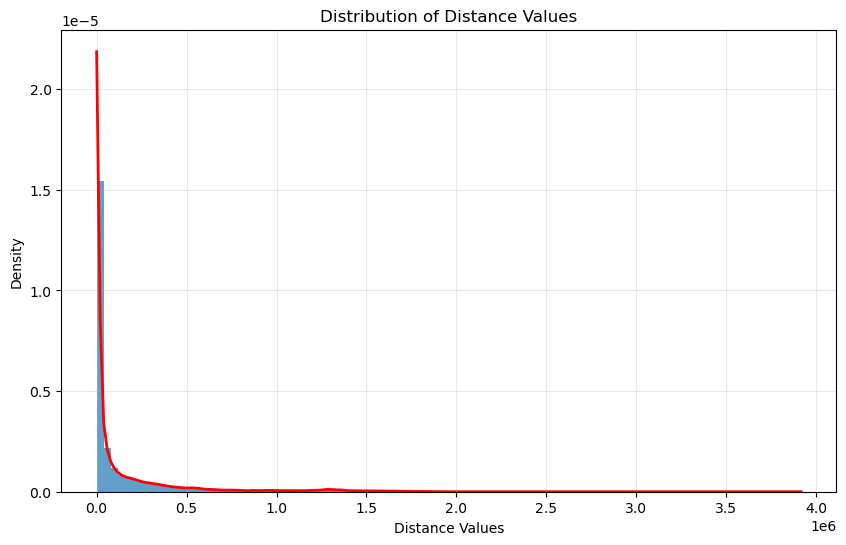

In [3]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.warp
import pyproj
import os
import warnings
import logging
import matplotlib.pyplot as plt

ca_ds = xr.open_dataset(r"D:\xarray\aligned2\powerdist\Powerdist.nc")

# Plot histogram of values
plt.figure(figsize=(10,6))
plt.hist(ca_ds.Powerdist.values.flatten(), bins=100, density=True, alpha=0.7)
plt.xlabel('Distance Values')
plt.ylabel('Density')
plt.title('Distribution of Distance Values')

# Add a kernel density estimate curve
from scipy import stats
values = ca_ds.Powerdist.values.flatten()
values = values[~np.isnan(values)]  # Remove NaN values
kernel = stats.gaussian_kde(values)
x_range = np.linspace(min(values), max(values), 200)
plt.plot(x_range, kernel(x_range), 'r-', lw=2)

plt.grid(True, alpha=0.3)
plt.show()

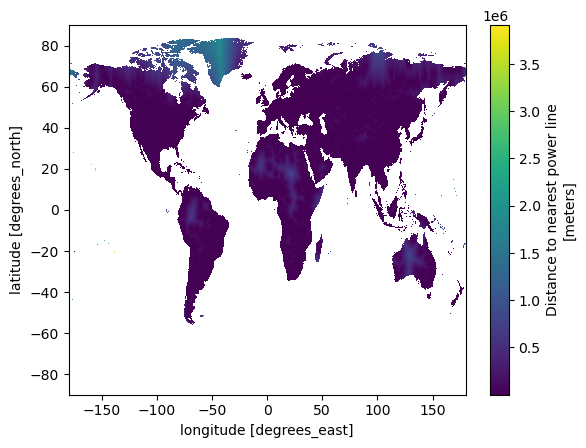

In [4]:
# Coarsen and plot the dataset
# Use boundary='trim' to handle dimensions that aren't exactly divisible by window size
coarsened = ca_ds.Powerdist.coarsen(lat=10, lon=10, boundary='trim').mean()
coarsened.plot()
plt.show()


In [14]:
# Save directly to netCDF without trying to drop spatial_ref since it doesn't exist
ds = xr.open_dataset(r'D:\xarray\aligned2\Feature_all\GURdist_2015.nc')

ds

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 1, lon: 43200, lat: 21600)
Coordinates:
  * time         (time) datetime64[ns] 8B 2015-01-01
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band         int32 4B ...
Data variables:
    GURdist      (time, lat, lon) float32 4GB ...

## 居民点修正

In [8]:
import os
import tempfile
import numpy as np
import xarray as xr
import rioxarray  # noqa: F401
from osgeo import gdal
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.windows import Window
import dask.array as da
from rasterio.transform import from_origin
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore', category=UserWarning, message='CRS mismatch')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')


def compute_gurs_distance_with_blocks(
    template_path: str,
    gurs_paths: list[str],
    output_dir: str,
    *,
    block_size: int = 5000,
    overlap: int = 500,
    land_mask_var: str = "land_mask",
    land_value: int = 1,
    proj_crs: str = "EPSG:6933",
    dtype: str = "float32",
    compress: bool = True
):
    """
    使用分块+WarpedVRT方式计算到最近GURS (值==1或2) 像元的距离，避免一次性重投影导致的内存暴涨。
    输出每个年份一个 NetCDF 文件，变量名 GURdist，坐标 (time, lat, lon)，time=YYYY-01-01。
    """

    # 1. 创建输出目录
    os.makedirs(output_dir, exist_ok=True)

    # 2. 读取并检查模板 NetCDF，确保含 CRS 和 land_mask_var
    print("🔄 读取原始模板并写入 CRS…")
    ds_orig = xr.open_dataset(template_path)
    try:
        ds_orig = ds_orig.rio.write_crs("EPSG:4326", inplace=False)
    except Exception:
        ds_orig = ds_orig

    if land_mask_var not in ds_orig:
        raise KeyError(f"模板中未找到 '{land_mask_var}' 变量")

    # 3. 将模板投影到目标 CRS，获取投影后掩膜 da_mask_proj
    print(f"🌐 将模板投影到 {proj_crs}…")
    try:
        ds_proj = ds_orig.rio.reproject(proj_crs)
    except Exception:
        ds_orig = ds_orig.rio.write_crs("EPSG:4326")
        ds_proj = ds_orig.rio.reproject(proj_crs)

    da_mask_proj = ds_proj[land_mask_var]
    transform_proj = da_mask_proj.rio.transform()       # 投影 CRS 下的 Affine
    crs_proj = da_mask_proj.rio.crs                   # 投影 CRS
    crs_proj_wkt = crs_proj.to_wkt()                   # 投影 CRS WKT 字符串
    height_proj, width_proj = da_mask_proj.shape
    pixel_size_proj = abs(da_mask_proj.rio.resolution()[0])  # 单位：米

    print(f"🗺 投影后网格大小: {height_proj} 行 × {width_proj} 列；像元大小 ≈ {pixel_size_proj:.2f} m")

    # 4. 遍历每个 GURS 文件
    for gurs_path in tqdm(gurs_paths, desc="处理年份", unit="年"):
        # 从文件名中提取年份
        year_str = os.path.splitext(os.path.basename(gurs_path))[0]
        if "_" in year_str and year_str.split("_")[-1].isdigit():
            yyyy = year_str.split("_")[-1]
        else:
            raise ValueError(f"无法从文件名 '{year_str}' 中提取年份，请确保格式如 'GURS_YYYY.tif'。")

        print(f"\n—— 处理年份 {yyyy} ——")

        # 4.1 打开 GURS 源文件，读取原始 CRS 和分辨率
        with rasterio.open(gurs_path) as src:
            orig_crs = src.crs.to_string()
            res_gurs = src.res
            print(f"   原始 GURS CRS: {orig_crs}")
            print(f"   原始 GURS 分辨率: {res_gurs[0]:.6f} × {res_gurs[1]:.6f} ({src.dtypes[0]})")

            # 4.2 创建 WarpedVRT，将其虚拟为投影 CRS + 投影网格对齐
            vrt_options = {
                "crs": proj_crs,                   # 目标 CRS
                "transform": transform_proj,       # 目标 Affine（Affine 对象）
                "width": width_proj,               # 目标宽度
                "height": height_proj,             # 目标高度
                "resampling": rasterio.enums.Resampling.nearest,
                # 如果 GURS 有 nodata，可以额外传 "dst_nodata": src.nodata
            }
            with WarpedVRT(src, **vrt_options) as vrt:
                """
                vrt: 虚拟文件，代表 GURS 重投影到 EPSG:6933 并对齐到 da_mask_proj 网格后的样子，
                     但并不实际占用全部内存。之后针对每个块用 `vrt.read(window=…)` 逐块读取。
                """

                # 4.3 准备一个全图大小的距离数组，后面分块计算再写入
                dist_m = np.zeros((height_proj, width_proj), dtype=np.float32)

                # 4.4 计算分块数目
                n_blocks_y = (height_proj + block_size - 1) // block_size
                n_blocks_x = (width_proj + block_size - 1) // block_size
                print(f"   ↳ 分块处理: 共 {n_blocks_y} 行块 × {n_blocks_x} 列块")

                driver = gdal.GetDriverByName("GTiff")

                def process_block(start_y: int, start_x: int, h: int, w: int) -> np.ndarray:
                    """
                    处理一个块（带 overlap）：
                    1. 用 vrt.read 读取该投影下块的数据
                    2. 将值==1 或 ==2 转为 1，其余为 0，生成 mask_uint8
                    3. 用 GDAL ComputeProximity 计算像素距离，再乘像元大小得到米距离
                    4. 裁剪 overlap 后返回核心 h×w 大小的距离块
                    """
                    # 4.5.1 计算带 overlap 的区域坐标
                    y0 = max(0, start_y - overlap)
                    x0 = max(0, start_x - overlap)
                    y1 = min(height_proj, start_y + h + overlap)
                    x1 = min(width_proj, start_x + w + overlap)
                    win_h = y1 - y0
                    win_w = x1 - x0

                    # 4.5.2 用 WarpedVRT 在该 window 里读取投影后值
                    window = Window(col_off=x0, row_off=y0, width=win_w, height=win_h)
                    arr_proj = vrt.read(1, window=window)

                    # 4.5.3 生成 0/1 掩膜
                    mask_bool = np.logical_or(arr_proj == 1, arr_proj == 2)
                    mask_uint8 = mask_bool.astype("uint8")

                    # 4.5.4 用 GDAL ComputeProximity 计算像素距离
                    with tempfile.TemporaryDirectory() as tmpdir:
                        mask_tif = os.path.join(tmpdir, "mask_block.tif")
                        dist_tif = os.path.join(tmpdir, "dist_block.tif")

                        # 4.5.4.1 构造该块在投影空间的 Affine
                        block_transform = from_origin(
                            transform_proj.c + x0 * transform_proj.a,
                            transform_proj.f + y0 * transform_proj.e,
                            transform_proj.a,
                            transform_proj.e
                        )

                        # 4.5.4.2 写入 mask_block.tif
                        ds_mask = driver.Create(mask_tif, win_w, win_h, 1, gdal.GDT_Byte)
                        ds_mask.SetGeoTransform(block_transform.to_gdal())
                        ds_mask.SetProjection(crs_proj_wkt)
                        band = ds_mask.GetRasterBand(1)
                        band.WriteArray(mask_uint8)
                        band.FlushCache()
                        ds_mask = None

                        # 4.5.4.3 创建 dist_block.tif 并 ComputeProximity
                        ds_dist = driver.Create(dist_tif, win_w, win_h, 1, gdal.GDT_Float32)
                        ds_dist.SetGeoTransform(block_transform.to_gdal())
                        ds_dist.SetProjection(crs_proj_wkt)

                        src_ds = gdal.Open(mask_tif)
                        src_band = src_ds.GetRasterBand(1)
                        dst_band = ds_dist.GetRasterBand(1)
                        gdal.ComputeProximity(src_band, dst_band, ["VALUES=1"])
                        ds_dist.FlushCache()
                        ds_dist = None
                        src_ds = None

                        # 4.5.4.4 读取 dist_block 并乘像元大小转换为米
                        with rasterio.open(dist_tif) as src_dist:
                            dist_block = src_dist.read(1)
                        dist_block = dist_block.astype(np.float32) * pixel_size_proj

                    # 4.5.5 裁剪掉 overlap 区域，只留核心部分
                    top = overlap if start_y > 0 else 0
                    left = overlap if start_x > 0 else 0
                    bottom = dist_block.shape[0] - (overlap if start_y + h < height_proj else 0)
                    right = dist_block.shape[1] - (overlap if start_x + w < width_proj else 0)

                    return dist_block[top:bottom, left:right]

                # 4.6 遍历所有块，调用 process_block 并写回 dist_m
                for by in range(n_blocks_y):
                    for bx in range(n_blocks_x):
                        sy = by * block_size
                        sx = bx * block_size
                        hh = min(block_size, height_proj - sy)
                        ww = min(block_size, width_proj - sx)

                        dist_m[sy: sy + hh, sx: sx + ww] = process_block(sy, sx, hh, ww)

        # 5. dist_m 填满后，下面把它变为 DataArray 并输出
        # 5.1 包装成投影空间下的 DataArray
        dist_da = xr.DataArray(
            da.from_array(dist_m, chunks=(block_size, block_size)),
            dims=("y", "x"),
            coords={
                "y": da_mask_proj.coords["y"].values,
                "x": da_mask_proj.coords["x"].values,
            },
            name="GURdist"
        ).rio.write_crs(proj_crs)

        # 5.2 将其重投影到原始模板的经纬度网格
        print("   ↳ 将距离场重投影回经纬度网格…")
        template_mask = ds_orig[land_mask_var]
        dist_da_latlon = dist_da.rio.reproject_match(template_mask)

        # 5.3 在经纬度网格上应用土地掩膜（非 land_value 设 NaN）
        print("   ↳ 应用土地掩膜…")
        mask_orig = (template_mask.values == land_value)
        dist_da_latlon = dist_da_latlon.where(mask_orig)

        # 5.4 添加 time 维度
        print("   ↳ 构造带时间维度的 DataArray…")
        time_coord = np.array([np.datetime64(f"{yyyy}-01-01")])
        dist_da_with_time = dist_da_latlon.expand_dims({"time": time_coord}, axis=0)
        dist_da_with_time.name = "GURdist"
        dist_da_with_time.attrs.update({
            "units": "meters",
            "long_name": f"Distance to GURS {yyyy} pixels (value=1 or 2)"
        })
        dist_da_with_time = dist_da_with_time.rio.write_crs(ds_orig.rio.crs)

        # 5.5 写出 NetCDF
        out_filename = os.path.join(output_dir, f"GURdist_{yyyy}.nc")
        print(f"   ↳ 保存结果到 {out_filename} …")
        encoding = {
            "GURdist": {
                "dtype": dtype,
                "zlib": compress,
                "complevel": 4 if compress else 0,
                "chunksizes": (1, block_size, block_size)
            }
        }
        write_task = dist_da_with_time.to_netcdf(
            out_filename,
            encoding=encoding,
            compute=False,
            engine="netcdf4"
        )
        write_task.compute()
        print(f"   ✅ {yyyy} 年处理完成\n")

    print("🎉 所有年份处理完毕。")


# ===== 使用示例 =====
if __name__ == "__main__":
    template_nc = "D:/xarray/aligned2/master_final.nc"
    gurs2015 = "D:/xarray/pre-process/GURS_2015.tif"
    gurs2020 = "D:/xarray/pre-process/GURS_2020.tif"
    output_dir = "D:/xarray/aligned2/GURdist"

    compute_gurs_distance_with_blocks(
        template_path=template_nc,
        gurs_paths=[gurs2020],
        output_dir=output_dir,
        block_size=1000,    # 根据内存调整
        overlap=300,        # 根据预期距离调整
        land_mask_var="land_mask",
        land_value=1,
        proj_crs="EPSG:6933",
        dtype="float32",
        compress=True
    )


🔄 读取原始模板并写入 CRS…
🌐 将模板投影到 EPSG:6933…
🗺 投影后网格大小: 18807 行 × 44487 列；像元大小 ≈ 780.79 m


处理年份:   0%|          | 0/1 [00:00<?, ?年/s]


—— 处理年份 2020 ——
   原始 GURS CRS: ESRI:54009
   原始 GURS 分辨率: 100.000000 × 100.000000 (uint8)
   ↳ 分块处理: 共 19 行块 × 45 列块
   ↳ 将距离场重投影回经纬度网格…
   ↳ 应用土地掩膜…
   ↳ 构造带时间维度的 DataArray…
   ↳ 保存结果到 D:/xarray/aligned2/GURdist\GURdist_2020.nc …


处理年份: 100%|██████████| 1/1 [09:46<00:00, 586.07s/年]

   ✅ 2020 年处理完成

🎉 所有年份处理完毕。



Clipped dataset info:
<xarray.Dataset> Size: 6MB
Dimensions:      (time: 1, lon: 1248, lat: 1140)
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-01-01
  * lon          (lon) float64 10kB -124.5 -124.5 -124.5 ... -114.1 -114.1
  * lat          (lat) float64 9kB 42.0 41.99 41.98 41.97 ... 32.52 32.51 32.5
Data variables:
    spatial_ref  int32 4B ...
    GURdist      (time, lat, lon) float32 6MB ...

GURdist data type: float32
GURdist shape: (1, 1140, 1248)

GURdist statistics:
Min value: 0.0
Max value: 105409.52
Mean value: 20038.58


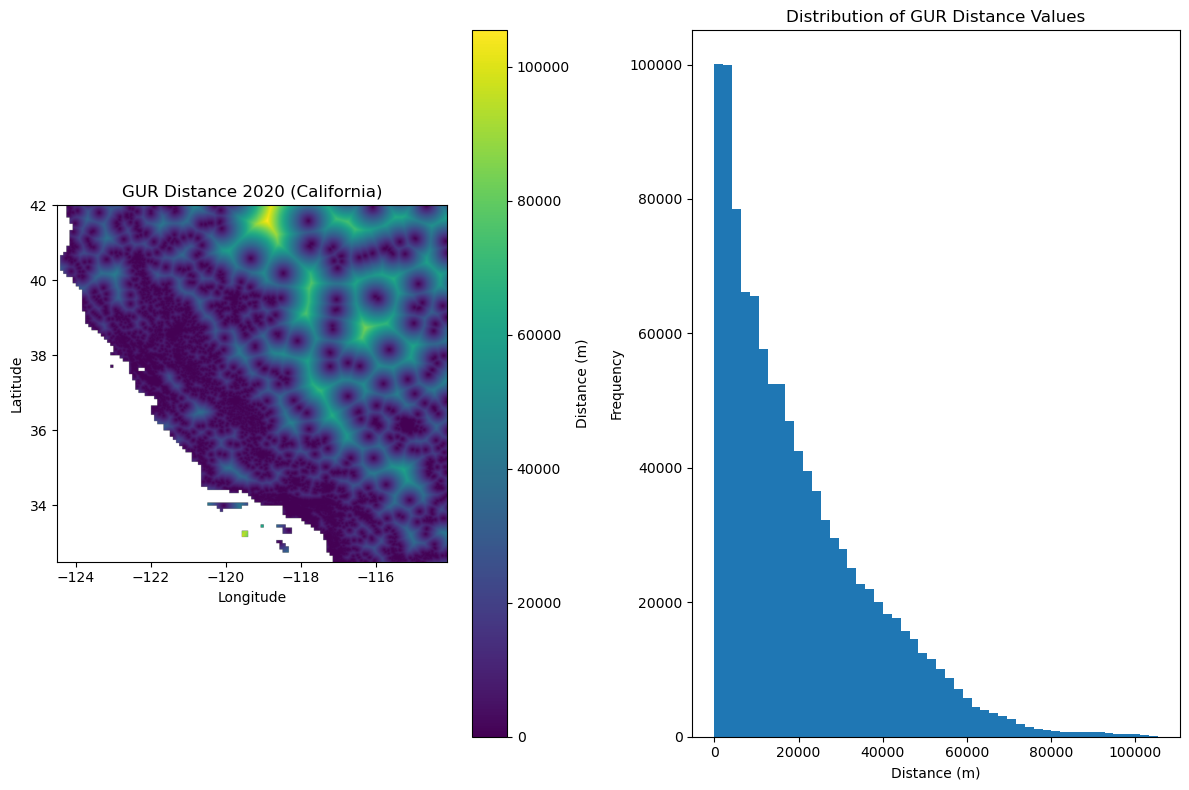

In [38]:
# Read the file
ca_bounds = {
    "minx": -124.5,
    "miny": 32.5,
    "maxx": -114.1,
    "maxy": 42.0
}

# Read and clip the data to California bounds
ds = xr.open_dataset(os.path.join(output_dir, "GURdist_2020_renamed.nc"))

# 注意：因为纬度是从北到南排序的，所以我们需要反转miny和maxy的顺序
ds_ca = ds.sel(
    lat=slice(ca_bounds["maxy"], ca_bounds["miny"]),  # 反转纬度范围的顺序
    lon=slice(ca_bounds["minx"], ca_bounds["maxx"])
)

# 打印裁剪后的数据信息
print("\nClipped dataset info:")
print(ds_ca)
print("\nGURdist data type:", ds_ca.GURdist.dtype)
print("GURdist shape:", ds_ca.GURdist.shape)

# 检查数据是否包含有效值
print("\nGURdist statistics:")
print("Min value:", ds_ca.GURdist.isel(time=0).min().values)
print("Max value:", ds_ca.GURdist.isel(time=0).max().values)
print("Mean value:", ds_ca.GURdist.isel(time=0).mean().values)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

# Plot spatial distribution
plot_data = ds_ca.GURdist.isel(time=0)

# 使用imshow而不是plot，这样可以更好地控制显示
im = ax1.imshow(
    plot_data,
    extent=[ca_bounds["minx"], ca_bounds["maxx"], ca_bounds["miny"], ca_bounds["maxy"]],
    aspect='equal',
    cmap='viridis'
)
plt.colorbar(im, ax=ax1, label='Distance (m)')
ax1.set_title("GUR Distance 2020 (California)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Plot histogram of values
ax2.hist(plot_data.values.flatten(), bins=50)
ax2.set_title("Distribution of GUR Distance Values")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Level 1 (0-5561m): 20.0%
Level 2 (5561-17031m): 20.0%
Level 3 (17031-46280m): 20.0%
Level 4 (46280-127147m): 20.0%
Level 5 (>127147m): 20.0%
Maximum distance value: 51169072m


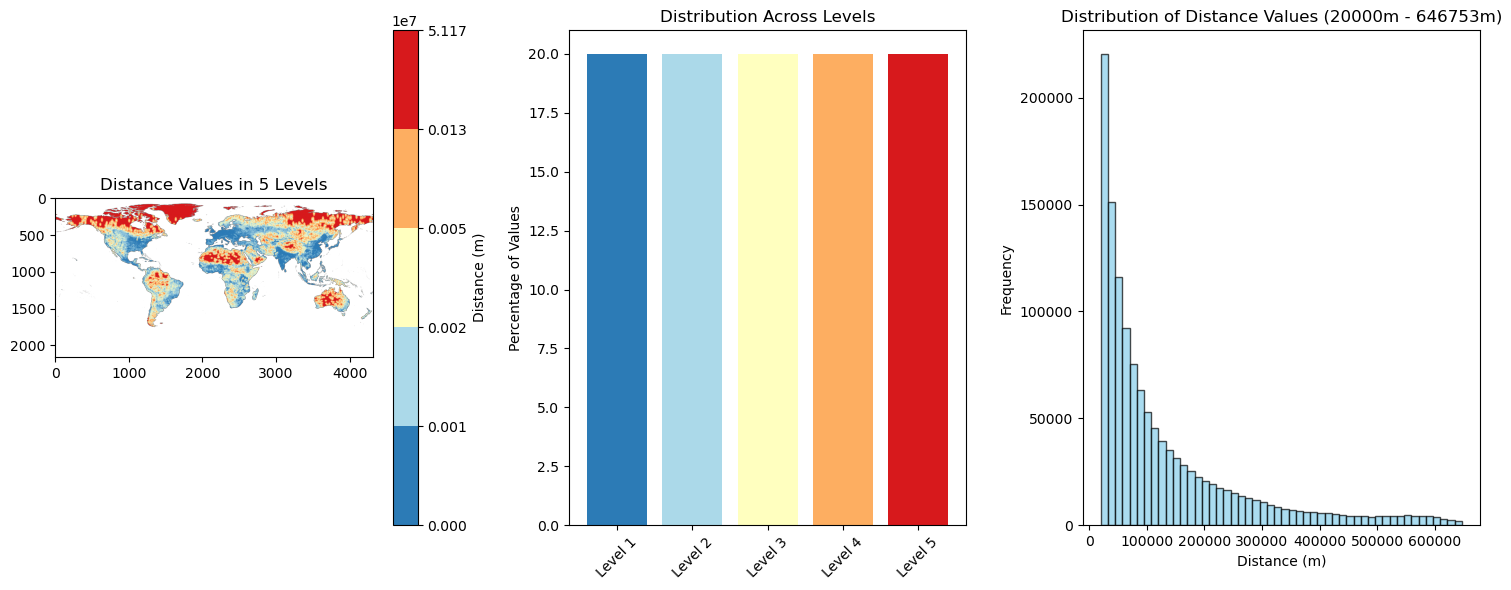

In [53]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# Load the dataset
ds = xr.open_dataset(os.path.join(output_dir, "GURdist_2020_renamed.nc"))

# Coarsen the data by taking mean over blocks
coarse_ds = ds.coarsen(lat=10, lon=10).mean()

# Convert to numpy array and get valid data
data = coarse_ds.GURdist.isel(time=0).values
valid_data = data[~np.isnan(data)].flatten()

# Calculate percentiles for 5 levels
percentiles = np.percentile(valid_data[valid_data > 0], [20, 40, 60, 80])
levels = [0] + list(percentiles) + [valid_data.max()]

# Create level labels
level_labels = [
    f'Level 1 (0-{levels[1]:.0f}m)',
    f'Level 2 ({levels[1]:.0f}-{levels[2]:.0f}m)',
    f'Level 3 ({levels[2]:.0f}-{levels[3]:.0f}m)', 
    f'Level 4 ({levels[3]:.0f}-{levels[4]:.0f}m)',
    f'Level 5 (>{levels[4]:.0f}m)'
]

# Create custom colormap for 5 levels
colors = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']
cmap = ListedColormap(colors)
norm = BoundaryNorm(levels, cmap.N)

# Calculate percentage in each level
level_counts = []
for i in range(len(levels)-1):
    count = np.sum((valid_data > levels[i]) & (valid_data <= levels[i+1]))
    percentage = (count / len(valid_data)) * 100
    level_counts.append(percentage)
    print(f"{level_labels[i]}: {percentage:.1f}%")

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# Plot 1: Data with 5 levels
im1 = ax1.imshow(data, cmap=cmap, norm=norm)
cbar = plt.colorbar(im1, ax=ax1)
cbar.set_label('Distance (m)')
ax1.set_title('Distance Values in 5 Levels')

# Plot 2: Distribution of levels
ax2.bar(range(5), level_counts, color=colors)
ax2.set_xticks(range(5))
ax2.set_xticklabels(['Level '+str(i+1) for i in range(5)], rotation=45)
ax2.set_ylabel('Percentage of Values')
ax2.set_title('Distribution Across Levels')

# Plot 3: Histogram with level boundaries
# Print maximum value
print(f"Maximum distance value: {valid_data.max():.0f}m")

# Calculate 99th percentile and plot histogram up to that value
percentile_99 = np.percentile(valid_data, 99)
filtered_data = valid_data[valid_data >= 20000]
filtered_data = filtered_data[filtered_data <= percentile_99]
ax3.hist(filtered_data, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax3.set_title(f'Distribution of Distance Values (20000m - {percentile_99:.0f}m)')
ax3.set_xlabel('Distance (m)')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 自然保护地数据修正

In [ ]:
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import numpy as np
from pathlib import Path
import rasterio
from rasterio import features
import gc
from tqdm.auto import tqdm
import psutil
import warnings
warnings.filterwarnings('ignore')

def print_memory_usage(msg=""):
    """Print current memory usage"""
    process = psutil.Process()
    print(f"{msg} Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def rasterize_gdf_chunk(gdf, transform, height, width, lat_slice, lon_slice):
    """
    Rasterize a chunk of the geodataframe
    """
    try:
        # Create an empty array for the chunk
        chunk_arr = np.zeros((height, width), dtype=np.bool_)
        
        # Rasterize the geometries
        shapes = [(geom, 1) for geom in gdf.geometry]
        chunk_arr = features.rasterize(
            shapes=shapes,
            out=chunk_arr,
            transform=transform,
            dtype=np.bool_,
            all_touched=True
        )
        return chunk_arr
    except Exception as e:
        print(f"Error rasterizing chunk: {str(e)}")
        return None

def process_protected_areas(gdfs, master_path, output_path, chunk_size=1000):
    """
    Convert multiple GeoDataFrames to a single NetCDF file matching the master template
    
    Parameters:
    -----------
    gdfs : list of GeoDataFrame
        List of protected area GeoDataFrames to process
    master_path : str or Path
        Path to the master NetCDF template
    output_path : str or Path
        Path to save the output NetCDF
    chunk_size : int
        Size of chunks for processing
    """
    print_memory_usage("Initial")
    
    # Load master template for reference
    with xr.open_dataset(master_path) as master:
        # Get spatial reference from master
        lat = master.lat.values
        lon = master.lon.values
        land_mask = master.land_mask.values
        
        # Create transform and dimensions matching master
        height = len(lat)
        width = len(lon)
        
        # Calculate transform from coordinates
        dx = (lon[-1] - lon[0]) / (width - 1)
        dy = (lat[-1] - lat[0]) / (height - 1)
        transform = rasterio.transform.from_origin(
            lon[0] - dx/2,  # Left edge
            lat[0] - dy/2,  # Top edge
            dx,            # Pixel width
            dy             # Pixel height
        )
        
        # Create empty array for results
        protected_area = np.zeros((height, width), dtype=np.bool_)
        
        # Process each GeoDataFrame
        for i, gdf in enumerate(gdfs, 1):
            print(f"\nProcessing GeoDataFrame {i}/{len(gdfs)}")
            
            # Ensure GDF is in the same CRS as master
            if gdf.crs != "EPSG:4326":
                gdf = gdf.to_crs("EPSG:4326")
            
            # Process in chunks
            for y in tqdm(range(0, height, chunk_size), desc="Processing latitude chunks"):
                y_end = min(y + chunk_size, height)
                lat_slice = slice(y, y_end)
                
                for x in range(0, width, chunk_size):
                    x_end = min(x + chunk_size, width)
                    lon_slice = slice(x, x_end)
                    
                    # Get bounds for current chunk
                    chunk_bounds = (
                        lon[x], lat[y_end],  # minx, miny
                        lon[x_end-1], lat[y]   # maxx, maxy  # Fix: Use x_end-1 to avoid index out of bounds
                    )
                    
                    # Clip GDF to chunk bounds
                    chunk_gdf = gdf.cx[chunk_bounds[0]:chunk_bounds[2], 
                                     chunk_bounds[1]:chunk_bounds[3]]
                    
                    chunk_arr = None  # Initialize chunk_arr
                    
                    if not chunk_gdf.empty:
                        chunk_arr = rasterize_gdf_chunk(
                            chunk_gdf,
                            transform,
                            y_end - y,
                            x_end - x,
                            lat_slice,
                            lon_slice
                        )
                        
                        if chunk_arr is not None:
                            # Update protected_area with OR operation
                            protected_area[y:y_end, x:x_end] |= chunk_arr
                    
                    # Clean up
                    del chunk_gdf
                    if chunk_arr is not None:
                        del chunk_arr
                    gc.collect()
                
                if (y // chunk_size) % 5 == 0:
                    print_memory_usage(f"After chunk at latitude {lat[y]:.2f}")
        
        # Create output dataset
        ds = xr.Dataset(
            data_vars={
                "protected_area": (("lat", "lon"), protected_area),
            },
            coords={
                "lat": lat,
                "lon": lon
            }
        )
        
        # Apply land mask
        ds["protected_area"] = ds.protected_area.where(master.land_mask == 1)
        
        # Set attributes
        ds.protected_area.attrs.update({
            "long_name": "Protected Area",
            "description": "Boolean mask indicating protected areas",
            "units": "1",
            "dtype": "bool"
        })
        
        # Save to NetCDF
        encoding = {
            "protected_area": {
                "dtype": "int8",  # Use int8 for boolean data
                "zlib": True,
                "complevel": 5,
                "_FillValue": -1,
                "chunksizes": (chunk_size, chunk_size)
            }
        }
        
        print("\nSaving to NetCDF...")
        ds.to_netcdf(
            output_path,
            encoding=encoding,
            engine="netcdf4"
        )
        
        print(f"✅ Successfully saved to: {output_path}")
        print_memory_usage("Final")

# Usage example
if __name__ == "__main__":
    # Paths
    MASTER = Path(r"D:\xarray\aligned2\master_final.nc")
    OUTPUT = Path(r"D:\xarray\aligned2\protect\protected_areas.nc")
    
    # Load GeoDataFrames
    shp_paths = [
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp1\WDPA_Apr2025_Public_shp-polygons.shp",
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp2\WDPA_Apr2025_Public_shp-polygons.shp",
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp3\WDPA_Apr2025_Public_shp-polygons.shp"
    ]
    
    gdfs = []
    for path in shp_paths:
        print(f"Loading {Path(path).name}...")
        gdf = gpd.read_file(path)
        gdfs.append(gdf)
    
    # Process all GeoDataFrames
    process_protected_areas(
        gdfs=gdfs,
        master_path=MASTER,
        output_path=OUTPUT,
        chunk_size=500
    )


# 森林碳累积速率预处理

In [9]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from tqdm import tqdm

# ───────── 配置 ─────────

MASTER   = r"D:\xarray\aligned2\master_final.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process")
OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 文件路径
file_path = SRC_DIR / "sequestration_rate__mean__aboveground__full_extent__Mg_C_ha_yr.tif"

# ───────── 1. 读取模板 & 掩膜 ─────────
print("读取模板和掩膜...")
tmpl = xr.open_dataset(MASTER)
lat  = tmpl["lat"]
lon  = tmpl["lon"]
mask = tmpl["land_mask"]

# 设置分块大小 - 较小的块以避免内存溢出
chunk_lat = 1000
chunk_lon = 1000

# ───────── 2. 读取数据 ─────────
print("读取数据...")
try:
    out_nc = OUT_DIR / "sequestration.nc"
    
    # 检查文件是否已存在
    if out_nc.exists():
        print(f"文件已存在，跳过: {out_nc.name}")
    else:
        # 创建结果数组
        result_shape = (len(lat), len(lon))
        result = np.full(result_shape, np.nan, dtype=np.float32)
        
        # 分块处理
        lat_chunks = np.array_split(np.arange(len(lat)), max(1, len(lat) // chunk_lat))
        lon_chunks = np.array_split(np.arange(len(lon)), max(1, len(lon) // chunk_lon))
        
        total_chunks = len(lat_chunks) * len(lon_chunks)
        with tqdm(total=total_chunks, desc="处理数据") as pbar:
            for i, lat_indices in enumerate(lat_chunks):
                lat_values = lat.values[lat_indices]
                lat_start, lat_end = lat_indices[0], lat_indices[-1] + 1
                
                for j, lon_indices in enumerate(lon_chunks):
                    lon_values = lon.values[lon_indices]
                    lon_start, lon_end = lon_indices[0], lon_indices[-1] + 1
                    
                    # 读取原始数据的这一块
                    with rasterio.open(file_path) as src:
                        da = (
                            rxr.open_rasterio(file_path, masked=True)
                            .isel(band=0)
                            .rio.set_spatial_dims("x", "y", inplace=False)
                            .rename({"x": "lon", "y": "lat"})
                        )
                        
                        # 只对当前块进行插值
                        chunk_result = da.interp(
                            lon=lon_values, 
                            lat=lat_values, 
                            method="nearest"
                        ).compute()
                        
                        # 将结果放入结果数组
                        result[lat_start:lat_end, lon_start:lon_end] = chunk_result.values
                        
                        # 清理内存
                        del da, chunk_result
                        gc.collect()
                    
                    pbar.update(1)
        
        # 创建新的DataArray
        print("创建最终数据集...")
        da_result = xr.DataArray(
            result,
            coords={"lat": lat, "lon": lon},
            dims=["lat", "lon"],
            name="sequestration"
        )
        
        # 应用掩膜
        da_masked = da_result.where(mask)
        
        # 构造输出数据集
        out_ds = da_masked.to_dataset()
        
        # 设置压缩和分块参数
        encoding = {
            "sequestration": {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon),
                "_FillValue": np.nan
            }
        }
        
        # 保存为NetCDF文件
        print(f"保存到 {out_nc}...")
        out_ds.to_netcdf(out_nc, encoding=encoding)
        out_ds.close()
        
        # 清理内存
        del da_result, da_masked, out_ds, result
        gc.collect()
        
except Exception as e:
    print(f"处理时出错: {str(e)}")
    if out_nc.exists() and out_nc.is_file():
        out_nc.unlink()  # 删除可能部分写入的文件
finally:
    gc.collect()

# 清理模板数据
del tmpl, lat, lon, mask
gc.collect()

print("✅ 森林累积速率:", OUT_DIR)

读取模板和掩膜...
读取数据...


处理数据: 100%|██████████| 903/903 [7:28:16<00:00, 29.79s/it]  


创建最终数据集...
保存到 D:\xarray\aligned2\emission\sequestration.nc...
✅ 森林累积速率: D:\xarray\aligned2\emission


In [8]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from tqdm import tqdm

MASTER   = r"D:\xarray\aligned2\master_final.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process")
OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 文件路径
file_path = SRC_DIR / "sequestration_rate__mean__aboveground__full_extent__Mg_C_ha_yr.tif"

print("获取文件信息...")
with rasterio.open(file_path) as src:
    print(f"Driver: {src.driver}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System: {src.crs}")
    print(f"Transform: {src.transform}")
    print(f"Data type: {src.dtypes[0]}")
    print("\nBand descriptions:")
    for i in range(src.count):
        desc = src.descriptions[i] if src.descriptions and i < len(src.descriptions) else f'Band_{i+1}'
        print(f"Band {i+1}: {desc}")

获取文件信息...
Driver: GTiff
Width: 43200
Height: 21600
Number of bands: 1
Coordinate Reference System: EPSG:4326
Transform: | 0.01, 0.00,-180.00|
| 0.00,-0.01, 90.00|
| 0.00, 0.00, 1.00|
Data type: float32

Band descriptions:
Band 1: None
